<h1>Import necessary libraries</h1>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU , ReLU, PReLU
from tensorflow.keras.layers import Conv2D ,Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np
import pandas as pd
from PIL import Image
import os 
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Dec 10 23:10:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    52W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# Configure tensorflow to only use the gpu (Run this only when you want to train on GPU)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("using GPU")
    except RuntimeError as e:
        print(e)

using GPU


<h1>Load dataset</h1>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/My Drive/data/', 
    label_mode=None, 
    color_mode='rgb',
    batch_size=128,
    image_size=(64, 64),
    shuffle=True
)

train_ds = train_ds.map(lambda x: ((x/127.5)-1)) 

Found 19520 files belonging to 1 classes.


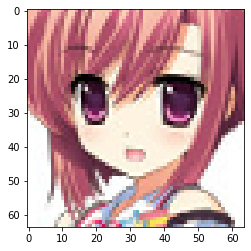

In [ ]:
plt.imshow(plt.imread('/content/drive/My Drive/data/1.png'))

<h1>Define Generator and Discriminator</h1>

In [ ]:
# Weights initializer
init = tf.keras.initializers.RandomNormal(stddev=0.02)

In [ ]:
def build_generator(seed_size):

    generator = Sequential()
  
    # Block - 1
    generator.add(Dense(4*4*1024,kernel_initializer=init,input_dim=seed_size))
    generator.add(BatchNormalization())
    generator.add(ReLU())
    generator.add(Reshape((4,4,1024))) # Resulting shape = (4,4,1024) 

    # Block - 2
    generator.add(Conv2DTranspose(512,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    generator.add(BatchNormalization())
    generator.add(ReLU())  # Resulting shape = (8,8,512)

    # Block - 3
    generator.add(Conv2DTranspose(256,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    generator.add(BatchNormalization())
    generator.add(ReLU()) # Resulting shape = (16,16,256)

    # Block - 4
    generator.add(Conv2DTranspose(128,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    generator.add(BatchNormalization())
    generator.add(ReLU()) # Resulting shape = (32,32,128)

    # Block - 5
    generator.add(Conv2DTranspose(3,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    generator.add(Activation('tanh')) # Resulting shape = (64,64,3)

    return generator

In [ ]:
def build_discriminator(image_length,image_channels):
    
    discriminator = Sequential()
    const = ClipConstraint(0.01)
  
    # Block - 1
    discriminator.add(Conv2D(64,kernel_size=3,strides=2,padding='same',use_bias=False,input_shape=(image_length,image_length,image_channels),kernel_initializer=init,kernel_constraint=const))
    discriminator.add(LeakyReLU(alpha=0.2)) # Resulting shape = (32,32,64)

    # Block - 2
    discriminator.add(Conv2D(128,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init,kernel_constraint=const))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(alpha=0.2)) # Resulting shape = (16,16,128)

    # Block - 3
    discriminator.add(Conv2D(256,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init,kernel_constraint=const))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(alpha=0.2)) # Resulting shape = (8,8,256)

    # Block - 4
    discriminator.add(Conv2D(512,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init,kernel_constraint=const))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(alpha=0.2)) # Resulting shape = (4,4,512)

    # Block - 5
    discriminator.add(Flatten())
    discriminator.add(Dense(1))
    #discriminator.add(Activation('sigmoid'))

    return discriminator

<h1>Define Keras Model</h1>

One-sided-label smoothing has been implemented (only for discriminator) to prevent the discriminator from overpowering the generator. Specifying this parameter changes the labels for real images from `1` to `(1-smooth)`. 

`smooth` parameter defined in the `discriminator_loss()` function takes care of this

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [ ]:
from keras import backend

# implementation of wasserstein loss
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

In [ ]:
from keras.constraints import Constraint
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value

	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)

	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

In [ ]:
class DCGAN(keras.Model):
    
    def __init__(self,seed_size,image_length,image_channels,**kwargs):

        super(DCGAN,self).__init__(**kwargs)

        self.generator = build_generator(seed_size)
        self.discriminator = build_discriminator(image_length,image_channels)
        self.seed_size = seed_size

        
           
    def generator_loss(self,fake_output):        
        return wasserstein_loss(tf.ones_like(fake_output)*(-1), fake_output)

       
    def discriminator_loss(self,real_output, fake_output,smooth=0.1):
        real_loss = wasserstein_loss(tf.ones_like(real_output)*(-1), real_output) 
        fake_loss = wasserstein_loss(tf.ones_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss
    
    def compile(self,generator_optimizer,discriminator_optimizer):
        super(DCGAN, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        
    @tf.function    
    def train_step(self,data):

        batch_size = tf.shape(data)[0]
        
        # feed a random input to generator
        seed = tf.random.normal(shape=(batch_size,self.seed_size))
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            
            # generate image using generator
            generated_image = self.generator(seed, training = True)
        
            # discriminator's prediction for real image
            real_output = self.discriminator(data,training = True)
            
            # discriminator's estimate for fake image
            fake_output = self.discriminator(generated_image,training = True) 
            
            # compute loss
            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output,fake_output)

            # optimize generator 
            generator_grad = gen_tape.gradient(gen_loss,self.generator.trainable_variables)
            discriminator_grad = disc_tape.gradient(disc_loss,self.discriminator.trainable_variables)

            # optimize discriminator 
            self.generator_optimizer.apply_gradients(zip(generator_grad,self.generator.trainable_variables))
            self.discriminator_optimizer.apply_gradients(zip(discriminator_grad,self.discriminator.trainable_variables))

            # optimize discriminator 
            self.generator_optimizer.apply_gradients(zip(generator_grad,self.generator.trainable_variables))
            self.discriminator_optimizer.apply_gradients(zip(discriminator_grad,self.discriminator.trainable_variables))
        
        return {
            "generator loss": gen_loss,
            "discriminator_loss": disc_loss
        }

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
# parameters and hyperparameters
image_length = 64
image_channels = 3
batch_size = 128
seed_size = 128

NUM_ROWS = 4  
NUM_COLS = 7
MARGIN = 16

#fixed_seed = tf.random.normal(shape=(NUM_ROWS * NUM_COLS, seed_size))

### Initialize the DCGAN

In [ ]:
generator_optimizer = RMSprop(lr=0.00005)
discriminator_optimizer = RMSprop(lr=0.00005)

dcgan = DCGAN(seed_size,image_length,image_channels)
dcgan.compile(generator_optimizer,discriminator_optimizer)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
          noise = tf.random.normal([10,seed_size])
          image = dcgan.generator(noise)
          plt.imshow(image[0].numpy().reshape(64,64,3)*0.5+0.5)
          plt.show()

<h1>Training</h1>

In [ ]:
tf.config.run_functions_eagerly(True)

Epoch 1/250
153/153 [==============================] - ETA: 0s - generator loss: 45.5180 - discriminator_loss: -104.1796

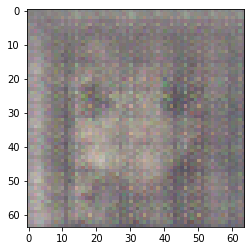

153/153 [==============================] - 252s 145ms/step - generator loss: 45.7908 - discriminator_loss: -104.4264
Epoch 2/250
153/153 [==============================] - ETA: 0s - generator loss: 118.7199 - discriminator_loss: -230.0157

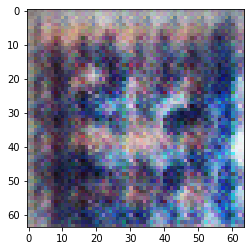

153/153 [==============================] - 22s 143ms/step - generator loss: 118.9289 - discriminator_loss: -230.5111
Epoch 3/250
153/153 [==============================] - ETA: 0s - generator loss: 177.1001 - discriminator_loss: -340.8086

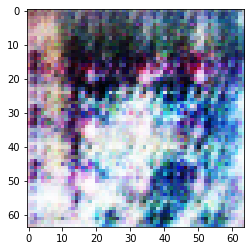

153/153 [==============================] - 22s 143ms/step - generator loss: 177.4941 - discriminator_loss: -341.3387
Epoch 4/250
153/153 [==============================] - ETA: 0s - generator loss: 229.5318 - discriminator_loss: -440.0228

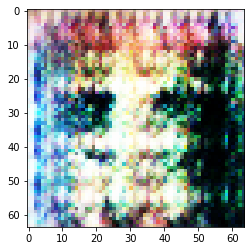

153/153 [==============================] - 22s 143ms/step - generator loss: 229.9941 - discriminator_loss: -440.2981
Epoch 5/250
153/153 [==============================] - ETA: 0s - generator loss: 288.1245 - discriminator_loss: -551.7695

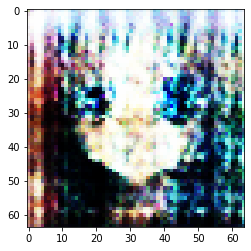

153/153 [==============================] - 22s 143ms/step - generator loss: 288.3911 - discriminator_loss: -552.4785
Epoch 6/250
153/153 [==============================] - ETA: 0s - generator loss: 346.2779 - discriminator_loss: -661.5385

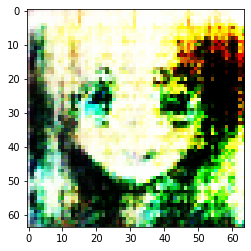

153/153 [==============================] - 22s 143ms/step - generator loss: 346.7981 - discriminator_loss: -661.1683
Epoch 7/250
153/153 [==============================] - ETA: 0s - generator loss: 398.5688 - discriminator_loss: -757.9560

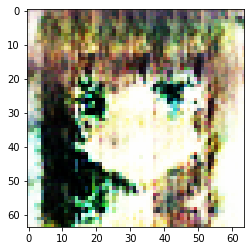

153/153 [==============================] - 22s 143ms/step - generator loss: 398.3180 - discriminator_loss: -758.7953
Epoch 8/250
153/153 [==============================] - ETA: 0s - generator loss: 456.4760 - discriminator_loss: -872.9375

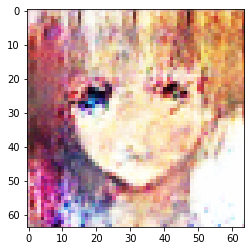

153/153 [==============================] - 22s 142ms/step - generator loss: 457.2602 - discriminator_loss: -874.0236
Epoch 9/250
153/153 [==============================] - ETA: 0s - generator loss: 512.4227 - discriminator_loss: -980.6890

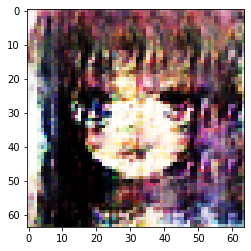

153/153 [==============================] - 22s 143ms/step - generator loss: 513.5141 - discriminator_loss: -981.8653
Epoch 10/250
153/153 [==============================] - ETA: 0s - generator loss: 583.1211 - discriminator_loss: -1119.9502

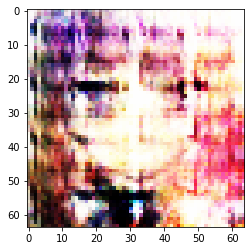

153/153 [==============================] - 22s 142ms/step - generator loss: 582.8334 - discriminator_loss: -1120.7030
Epoch 11/250
153/153 [==============================] - ETA: 0s - generator loss: 654.8588 - discriminator_loss: -1277.4431

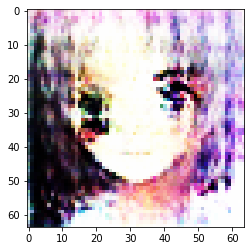

153/153 [==============================] - 22s 144ms/step - generator loss: 653.1117 - discriminator_loss: -1277.1701
Epoch 12/250
153/153 [==============================] - ETA: 0s - generator loss: 720.3542 - discriminator_loss: -1406.6918

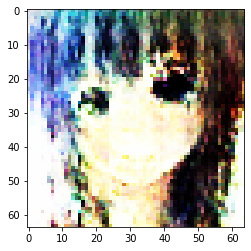

153/153 [==============================] - 22s 142ms/step - generator loss: 718.0922 - discriminator_loss: -1406.3798
Epoch 13/250
153/153 [==============================] - ETA: 0s - generator loss: 795.4850 - discriminator_loss: -1542.4759

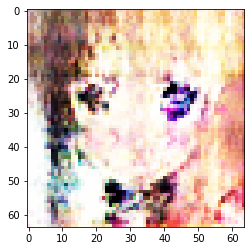

153/153 [==============================] - 22s 143ms/step - generator loss: 797.4044 - discriminator_loss: -1541.8879
Epoch 14/250
153/153 [==============================] - ETA: 0s - generator loss: 891.6536 - discriminator_loss: -1752.8801

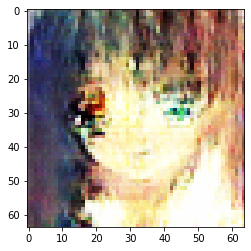

153/153 [==============================] - 22s 143ms/step - generator loss: 890.6808 - discriminator_loss: -1753.3875
Epoch 15/250
153/153 [==============================] - ETA: 0s - generator loss: 965.3493 - discriminator_loss: -1916.9272

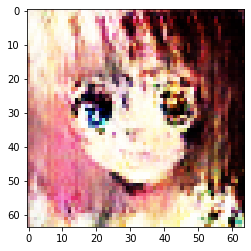

153/153 [==============================] - 22s 144ms/step - generator loss: 965.3100 - discriminator_loss: -1918.8597
Epoch 16/250
153/153 [==============================] - ETA: 0s - generator loss: 1070.9350 - discriminator_loss: -2125.7794

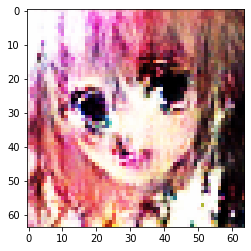

153/153 [==============================] - 22s 143ms/step - generator loss: 1073.0907 - discriminator_loss: -2123.6144
Epoch 17/250
153/153 [==============================] - ETA: 0s - generator loss: 1141.7296 - discriminator_loss: -2307.4901

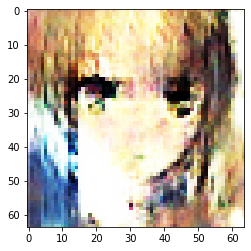

153/153 [==============================] - 22s 144ms/step - generator loss: 1141.4182 - discriminator_loss: -2309.1173
Epoch 18/250
153/153 [==============================] - ETA: 0s - generator loss: 1254.3838 - discriminator_loss: -2506.8998

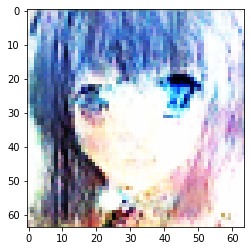

153/153 [==============================] - 22s 144ms/step - generator loss: 1255.2103 - discriminator_loss: -2509.9459
Epoch 19/250
153/153 [==============================] - ETA: 0s - generator loss: 1325.0699 - discriminator_loss: -2690.4315

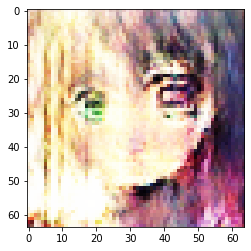

153/153 [==============================] - 22s 144ms/step - generator loss: 1326.8426 - discriminator_loss: -2688.6835
Epoch 20/250
153/153 [==============================] - ETA: 0s - generator loss: 1471.5490 - discriminator_loss: -2954.9086

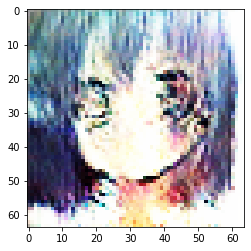

153/153 [==============================] - 22s 144ms/step - generator loss: 1474.0348 - discriminator_loss: -2953.7693
Epoch 21/250
153/153 [==============================] - ETA: 0s - generator loss: 1537.7303 - discriminator_loss: -3123.9821

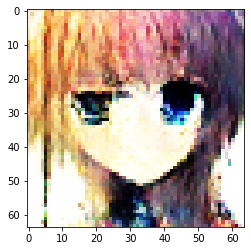

153/153 [==============================] - 23s 144ms/step - generator loss: 1537.6499 - discriminator_loss: -3126.7508
Epoch 22/250
153/153 [==============================] - ETA: 0s - generator loss: 1651.9028 - discriminator_loss: -3358.6437

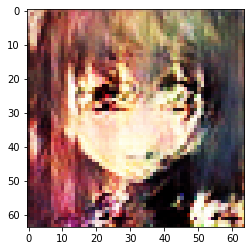

153/153 [==============================] - 23s 145ms/step - generator loss: 1654.4112 - discriminator_loss: -3362.7619
Epoch 23/250
153/153 [==============================] - ETA: 0s - generator loss: 1772.9404 - discriminator_loss: -3585.3924

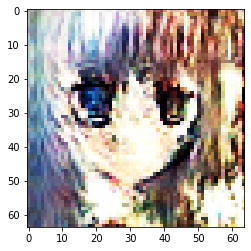

153/153 [==============================] - 23s 145ms/step - generator loss: 1776.4611 - discriminator_loss: -3582.8388
Epoch 24/250
153/153 [==============================] - ETA: 0s - generator loss: 1820.6052 - discriminator_loss: -3711.3517

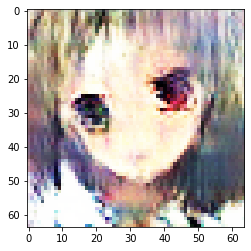

153/153 [==============================] - 22s 143ms/step - generator loss: 1824.5764 - discriminator_loss: -3709.4967
Epoch 25/250
153/153 [==============================] - ETA: 0s - generator loss: 1918.9501 - discriminator_loss: -3930.8203

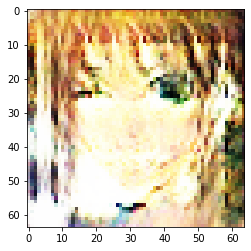

153/153 [==============================] - 22s 144ms/step - generator loss: 1917.5293 - discriminator_loss: -3931.8811
Epoch 26/250
153/153 [==============================] - ETA: 0s - generator loss: 2016.0424 - discriminator_loss: -4130.1849

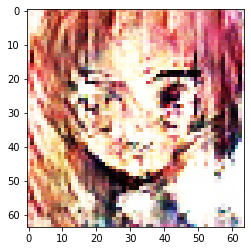

153/153 [==============================] - 22s 144ms/step - generator loss: 2007.6481 - discriminator_loss: -4125.4919
Epoch 27/250
153/153 [==============================] - ETA: 0s - generator loss: 2102.3559 - discriminator_loss: -4292.7496

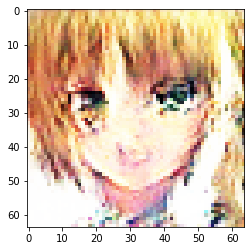

153/153 [==============================] - 22s 144ms/step - generator loss: 2102.0724 - discriminator_loss: -4295.8829
Epoch 28/250
153/153 [==============================] - ETA: 0s - generator loss: 2197.4618 - discriminator_loss: -4538.5685

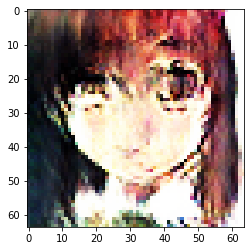

153/153 [==============================] - 22s 144ms/step - generator loss: 2195.1589 - discriminator_loss: -4540.3562
Epoch 29/250
153/153 [==============================] - ETA: 0s - generator loss: 2282.0087 - discriminator_loss: -4707.1028

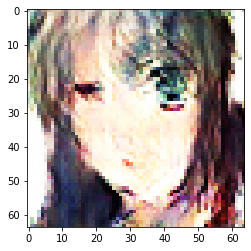

153/153 [==============================] - 22s 143ms/step - generator loss: 2280.4874 - discriminator_loss: -4710.8454
Epoch 30/250
153/153 [==============================] - ETA: 0s - generator loss: 2420.5870 - discriminator_loss: -4956.8592

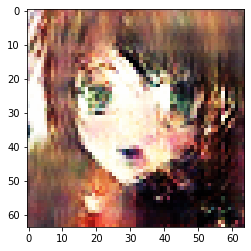

153/153 [==============================] - 22s 144ms/step - generator loss: 2412.7197 - discriminator_loss: -4953.9456
Epoch 31/250
153/153 [==============================] - ETA: 0s - generator loss: 2561.0696 - discriminator_loss: -5224.8277

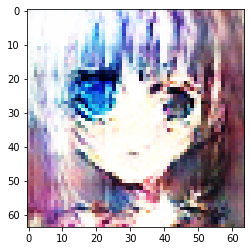

153/153 [==============================] - 22s 144ms/step - generator loss: 2547.3652 - discriminator_loss: -5217.4166
Epoch 32/250
153/153 [==============================] - ETA: 0s - generator loss: 2576.9162 - discriminator_loss: -5306.2263

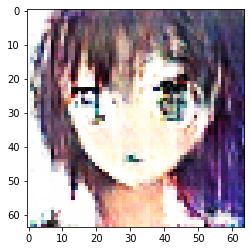

153/153 [==============================] - 22s 143ms/step - generator loss: 2572.8153 - discriminator_loss: -5308.3645
Epoch 33/250
153/153 [==============================] - ETA: 0s - generator loss: 2604.0006 - discriminator_loss: -5412.7062

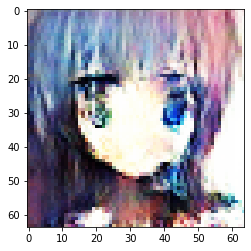

153/153 [==============================] - 22s 143ms/step - generator loss: 2611.0155 - discriminator_loss: -5420.7857
Epoch 34/250
153/153 [==============================] - ETA: 0s - generator loss: 2757.1544 - discriminator_loss: -5687.9384

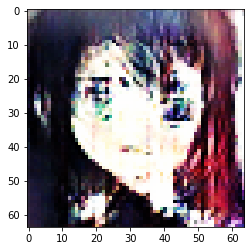

153/153 [==============================] - 22s 143ms/step - generator loss: 2752.2808 - discriminator_loss: -5690.0378
Epoch 35/250
153/153 [==============================] - ETA: 0s - generator loss: 2803.2016 - discriminator_loss: -5741.8062

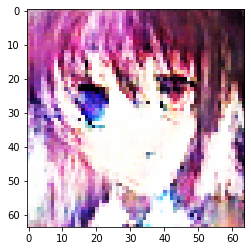

153/153 [==============================] - 23s 145ms/step - generator loss: 2811.1890 - discriminator_loss: -5739.6053
Epoch 36/250
153/153 [==============================] - ETA: 0s - generator loss: 2848.4415 - discriminator_loss: -5886.0054

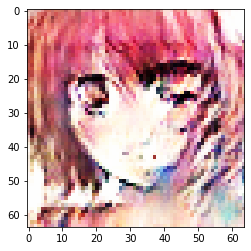

153/153 [==============================] - 23s 144ms/step - generator loss: 2837.1677 - discriminator_loss: -5883.4186
Epoch 37/250
153/153 [==============================] - ETA: 0s - generator loss: 2920.6176 - discriminator_loss: -6078.5665

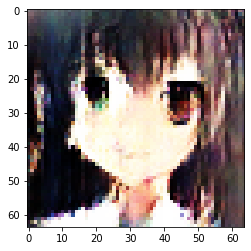

153/153 [==============================] - 23s 144ms/step - generator loss: 2913.7466 - discriminator_loss: -6078.8906
Epoch 38/250
153/153 [==============================] - ETA: 0s - generator loss: 3074.3597 - discriminator_loss: -6327.0375

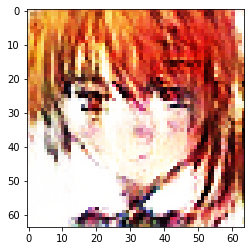

153/153 [==============================] - 22s 144ms/step - generator loss: 3084.1627 - discriminator_loss: -6330.5365
Epoch 39/250
153/153 [==============================] - ETA: 0s - generator loss: 3127.6566 - discriminator_loss: -6493.9699

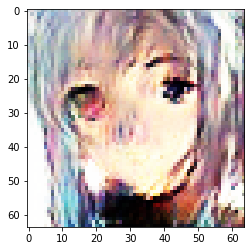

153/153 [==============================] - 22s 144ms/step - generator loss: 3120.9791 - discriminator_loss: -6496.5197
Epoch 40/250
153/153 [==============================] - ETA: 0s - generator loss: 3211.5142 - discriminator_loss: -6678.2463

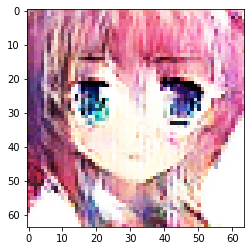

153/153 [==============================] - 23s 145ms/step - generator loss: 3220.6224 - discriminator_loss: -6677.1743
Epoch 41/250
153/153 [==============================] - ETA: 0s - generator loss: 3274.2727 - discriminator_loss: -6808.3285

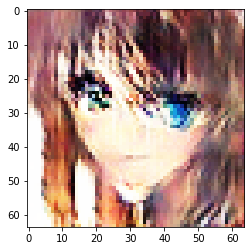

153/153 [==============================] - 22s 144ms/step - generator loss: 3266.4554 - discriminator_loss: -6810.6925
Epoch 42/250
153/153 [==============================] - ETA: 0s - generator loss: 3427.0315 - discriminator_loss: -7091.1037

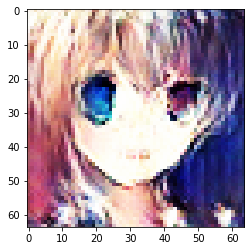

153/153 [==============================] - 22s 144ms/step - generator loss: 3436.8052 - discriminator_loss: -7095.6367
Epoch 43/250
153/153 [==============================] - ETA: 0s - generator loss: 3495.2679 - discriminator_loss: -7273.8038

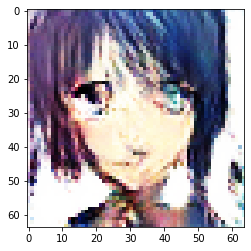

153/153 [==============================] - 23s 145ms/step - generator loss: 3483.2356 - discriminator_loss: -7272.6341
Epoch 44/250
153/153 [==============================] - ETA: 0s - generator loss: 3599.4729 - discriminator_loss: -7451.8072

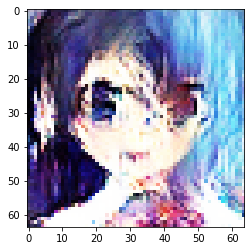

153/153 [==============================] - 22s 144ms/step - generator loss: 3611.4471 - discriminator_loss: -7455.8301
Epoch 45/250
153/153 [==============================] - ETA: 0s - generator loss: 3679.2154 - discriminator_loss: -7696.5655

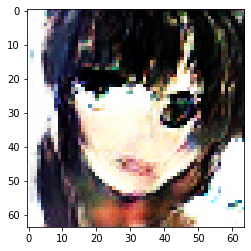

153/153 [==============================] - 22s 144ms/step - generator loss: 3670.2441 - discriminator_loss: -7698.5357
Epoch 46/250
153/153 [==============================] - ETA: 0s - generator loss: 3739.7953 - discriminator_loss: -7807.5883

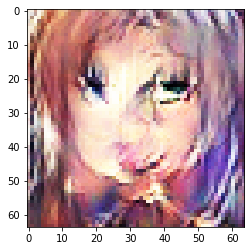

153/153 [==============================] - 22s 144ms/step - generator loss: 3753.5585 - discriminator_loss: -7815.4774
Epoch 47/250
153/153 [==============================] - ETA: 0s - generator loss: 3820.8247 - discriminator_loss: -8002.9367

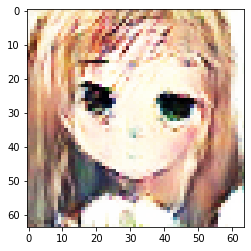

153/153 [==============================] - 23s 144ms/step - generator loss: 3813.1293 - discriminator_loss: -8009.2824
Epoch 48/250
153/153 [==============================] - ETA: 0s - generator loss: 3912.2503 - discriminator_loss: -8178.8575

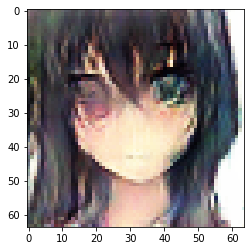

153/153 [==============================] - 22s 144ms/step - generator loss: 3927.0566 - discriminator_loss: -8177.9085
Epoch 49/250
153/153 [==============================] - ETA: 0s - generator loss: 4037.0595 - discriminator_loss: -8463.6347

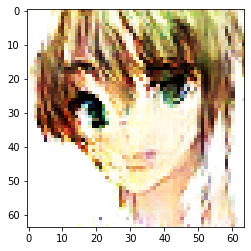

153/153 [==============================] - 22s 144ms/step - generator loss: 4027.1067 - discriminator_loss: -8467.8711
Epoch 50/250
153/153 [==============================] - ETA: 0s - generator loss: 4111.7646 - discriminator_loss: -8581.9538

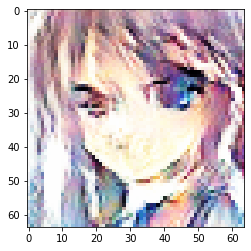

153/153 [==============================] - 22s 143ms/step - generator loss: 4127.3722 - discriminator_loss: -8583.7259
Epoch 51/250
153/153 [==============================] - ETA: 0s - generator loss: 4180.8003 - discriminator_loss: -8785.4386

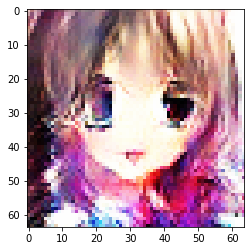

153/153 [==============================] - 23s 144ms/step - generator loss: 4157.9753 - discriminator_loss: -8776.9778
Epoch 52/250
153/153 [==============================] - ETA: 0s - generator loss: 4246.9163 - discriminator_loss: -8909.4012

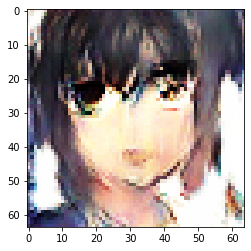

153/153 [==============================] - 22s 144ms/step - generator loss: 4261.7844 - discriminator_loss: -8916.3239
Epoch 53/250
153/153 [==============================] - ETA: 0s - generator loss: 4271.3599 - discriminator_loss: -9087.1663

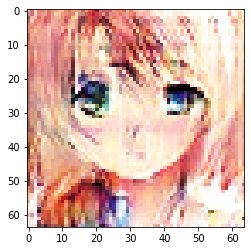

153/153 [==============================] - 22s 143ms/step - generator loss: 4253.2594 - discriminator_loss: -9085.1681
Epoch 54/250
153/153 [==============================] - ETA: 0s - generator loss: 4432.1616 - discriminator_loss: -9300.5685

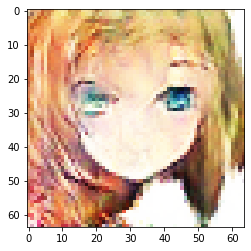

153/153 [==============================] - 23s 145ms/step - generator loss: 4449.6196 - discriminator_loss: -9298.5495
Epoch 55/250
153/153 [==============================] - ETA: 0s - generator loss: 4549.6922 - discriminator_loss: -9581.1502

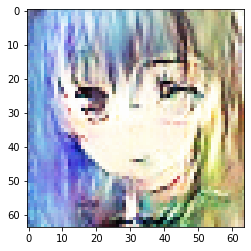

153/153 [==============================] - 23s 144ms/step - generator loss: 4528.4696 - discriminator_loss: -9574.9592
Epoch 56/250
153/153 [==============================] - ETA: 0s - generator loss: 4622.1107 - discriminator_loss: -9752.6619

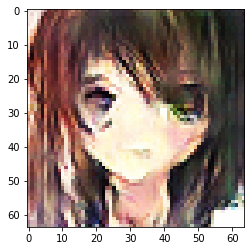

153/153 [==============================] - 22s 144ms/step - generator loss: 4640.5643 - discriminator_loss: -9751.3450
Epoch 57/250
153/153 [==============================] - ETA: 0s - generator loss: 4721.4185 - discriminator_loss: -9985.6668

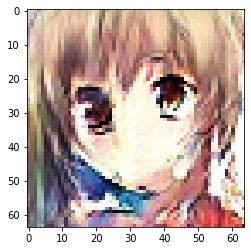

153/153 [==============================] - 23s 144ms/step - generator loss: 4691.1413 - discriminator_loss: -9975.9658
Epoch 58/250
153/153 [==============================] - ETA: 0s - generator loss: 4852.1712 - discriminator_loss: -10217.3553

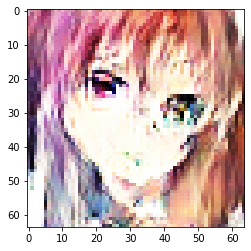

153/153 [==============================] - 22s 143ms/step - generator loss: 4871.7909 - discriminator_loss: -10229.2393
Epoch 59/250
153/153 [==============================] - ETA: 0s - generator loss: 4944.4231 - discriminator_loss: -10460.5979

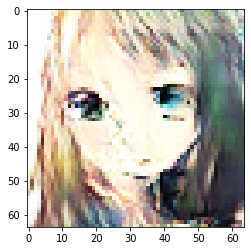

153/153 [==============================] - 22s 144ms/step - generator loss: 4921.6191 - discriminator_loss: -10458.7518
Epoch 60/250
153/153 [==============================] - ETA: 0s - generator loss: 5083.4883 - discriminator_loss: -10727.4127

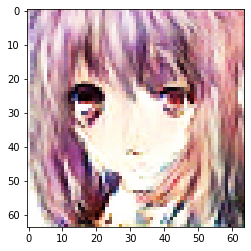

153/153 [==============================] - 23s 145ms/step - generator loss: 5105.5736 - discriminator_loss: -10730.3969
Epoch 61/250
153/153 [==============================] - ETA: 0s - generator loss: 5161.6831 - discriminator_loss: -10938.8120

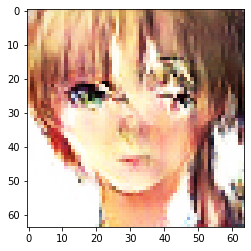

153/153 [==============================] - 22s 144ms/step - generator loss: 5142.4708 - discriminator_loss: -10940.8821
Epoch 62/250
153/153 [==============================] - ETA: 0s - generator loss: 5358.8099 - discriminator_loss: -11231.6804

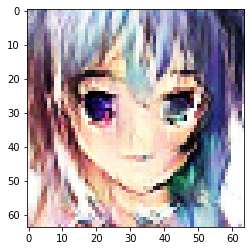

153/153 [==============================] - 22s 144ms/step - generator loss: 5384.2467 - discriminator_loss: -11231.8422
Epoch 63/250
153/153 [==============================] - ETA: 0s - generator loss: 5347.5232 - discriminator_loss: -11406.1441

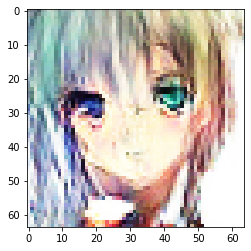

153/153 [==============================] - 22s 144ms/step - generator loss: 5306.3848 - discriminator_loss: -11389.0752
Epoch 64/250
153/153 [==============================] - ETA: 0s - generator loss: 5567.5232 - discriminator_loss: -11701.8379

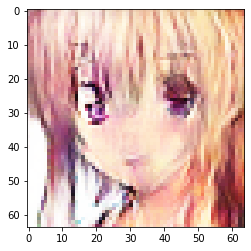

153/153 [==============================] - 22s 144ms/step - generator loss: 5590.9912 - discriminator_loss: -11709.1918
Epoch 65/250
153/153 [==============================] - ETA: 0s - generator loss: 5620.2436 - discriminator_loss: -11912.5952

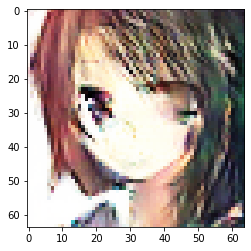

153/153 [==============================] - 22s 144ms/step - generator loss: 5584.8768 - discriminator_loss: -11901.2742
Epoch 66/250
153/153 [==============================] - ETA: 0s - generator loss: 5785.6231 - discriminator_loss: -12210.6550

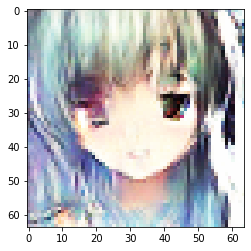

153/153 [==============================] - 22s 144ms/step - generator loss: 5809.8135 - discriminator_loss: -12214.8285
Epoch 67/250
153/153 [==============================] - ETA: 0s - generator loss: 5786.6588 - discriminator_loss: -12374.5198

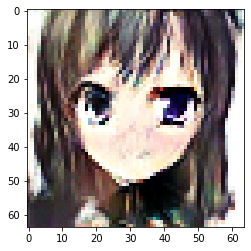

153/153 [==============================] - 22s 144ms/step - generator loss: 5750.0131 - discriminator_loss: -12363.2819
Epoch 68/250
153/153 [==============================] - ETA: 0s - generator loss: 5976.5181 - discriminator_loss: -12600.2305

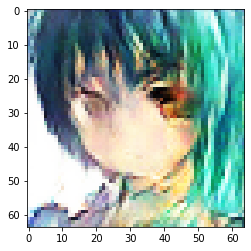

153/153 [==============================] - 23s 145ms/step - generator loss: 5999.4566 - discriminator_loss: -12597.8815
Epoch 69/250
153/153 [==============================] - ETA: 0s - generator loss: 6020.7858 - discriminator_loss: -12848.1767

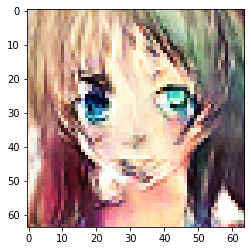

153/153 [==============================] - 23s 145ms/step - generator loss: 5994.9062 - discriminator_loss: -12847.7845
Epoch 70/250
153/153 [==============================] - ETA: 0s - generator loss: 6187.2577 - discriminator_loss: -13079.4338

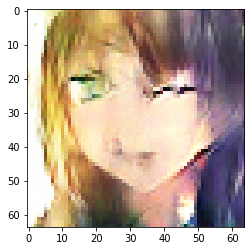

153/153 [==============================] - 22s 143ms/step - generator loss: 6216.9611 - discriminator_loss: -13080.3017
Epoch 71/250
153/153 [==============================] - ETA: 0s - generator loss: 6281.6644 - discriminator_loss: -13397.7415

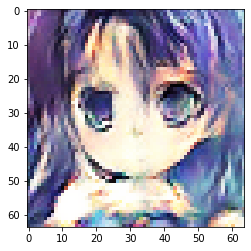

153/153 [==============================] - 22s 143ms/step - generator loss: 6245.9084 - discriminator_loss: -13388.3249
Epoch 72/250
153/153 [==============================] - ETA: 0s - generator loss: 6408.2967 - discriminator_loss: -13639.1945

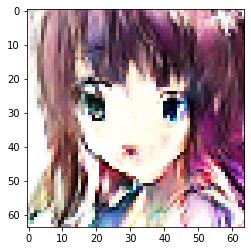

153/153 [==============================] - 22s 144ms/step - generator loss: 6439.8541 - discriminator_loss: -13631.4108
Epoch 73/250
153/153 [==============================] - ETA: 0s - generator loss: 6464.5021 - discriminator_loss: -13866.2671

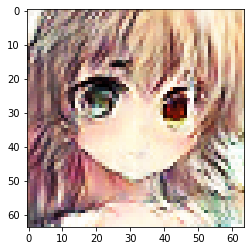

153/153 [==============================] - 22s 143ms/step - generator loss: 6429.0600 - discriminator_loss: -13856.3753
Epoch 74/250
153/153 [==============================] - ETA: 0s - generator loss: 6579.7543 - discriminator_loss: -14017.7054

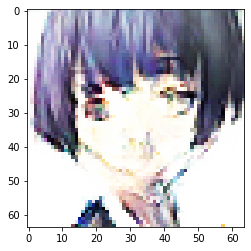

153/153 [==============================] - 23s 145ms/step - generator loss: 6612.4978 - discriminator_loss: -14004.1946
Epoch 75/250
153/153 [==============================] - ETA: 0s - generator loss: 6654.9936 - discriminator_loss: -14374.7595

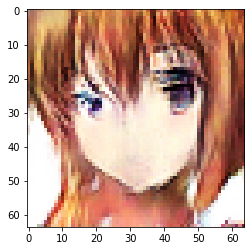

153/153 [==============================] - 23s 146ms/step - generator loss: 6618.6449 - discriminator_loss: -14370.3082
Epoch 76/250
153/153 [==============================] - ETA: 0s - generator loss: 6866.2454 - discriminator_loss: -14541.3801

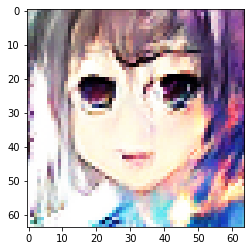

153/153 [==============================] - 22s 144ms/step - generator loss: 6895.2056 - discriminator_loss: -14542.7883
Epoch 77/250
153/153 [==============================] - ETA: 0s - generator loss: 6838.6492 - discriminator_loss: -14835.6139

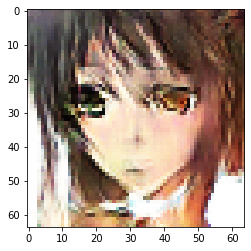

153/153 [==============================] - 23s 145ms/step - generator loss: 6806.6281 - discriminator_loss: -14834.1919
Epoch 78/250
153/153 [==============================] - ETA: 0s - generator loss: 7027.1926 - discriminator_loss: -15029.3040

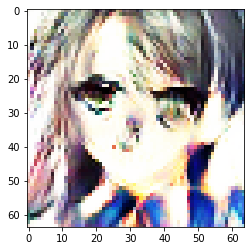

153/153 [==============================] - 23s 145ms/step - generator loss: 7062.4422 - discriminator_loss: -15035.1932
Epoch 79/250
153/153 [==============================] - ETA: 0s - generator loss: 7092.3186 - discriminator_loss: -15333.5898

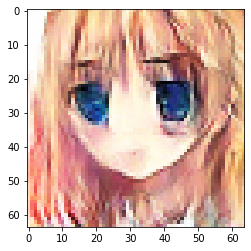

153/153 [==============================] - 23s 145ms/step - generator loss: 7069.2267 - discriminator_loss: -15344.0184
Epoch 80/250
153/153 [==============================] - ETA: 0s - generator loss: 7269.4984 - discriminator_loss: -15564.9143

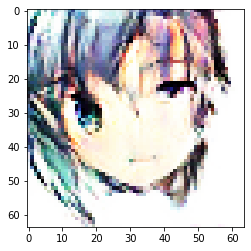

153/153 [==============================] - 23s 144ms/step - generator loss: 7305.2816 - discriminator_loss: -15563.9710
Epoch 81/250
153/153 [==============================] - ETA: 0s - generator loss: 7287.4655 - discriminator_loss: -15781.3393

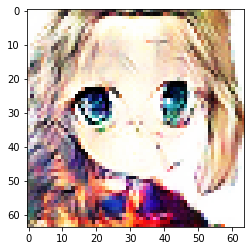

153/153 [==============================] - 22s 143ms/step - generator loss: 7267.9791 - discriminator_loss: -15794.5814
Epoch 82/250
153/153 [==============================] - ETA: 0s - generator loss: 7481.1477 - discriminator_loss: -16117.1494

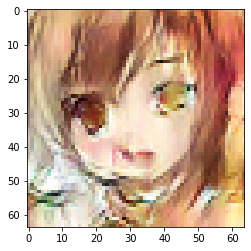

153/153 [==============================] - 22s 144ms/step - generator loss: 7518.9955 - discriminator_loss: -16129.5642
Epoch 83/250
153/153 [==============================] - ETA: 0s - generator loss: 7599.1775 - discriminator_loss: -16400.2604

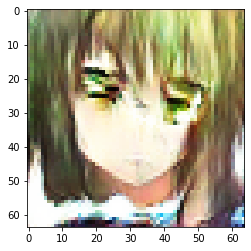

153/153 [==============================] - 22s 144ms/step - generator loss: 7564.4807 - discriminator_loss: -16399.9488
Epoch 84/250
153/153 [==============================] - ETA: 0s - generator loss: 7689.8173 - discriminator_loss: -16664.6817

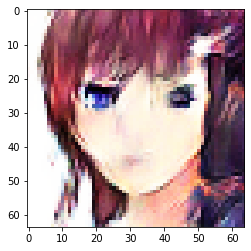

153/153 [==============================] - 23s 144ms/step - generator loss: 7724.8965 - discriminator_loss: -16660.6780
Epoch 85/250
153/153 [==============================] - ETA: 0s - generator loss: 7806.3997 - discriminator_loss: -16929.5920

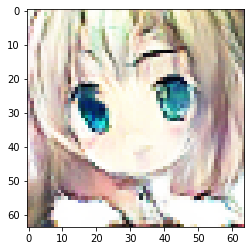

153/153 [==============================] - 23s 146ms/step - generator loss: 7758.0206 - discriminator_loss: -16922.1877
Epoch 86/250
153/153 [==============================] - ETA: 0s - generator loss: 8000.6384 - discriminator_loss: -17251.9994

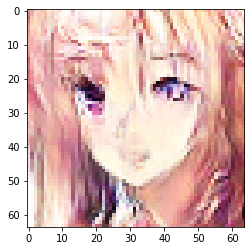

153/153 [==============================] - 22s 144ms/step - generator loss: 8035.0202 - discriminator_loss: -17249.0527
Epoch 87/250
153/153 [==============================] - ETA: 0s - generator loss: 8016.4091 - discriminator_loss: -17489.7653

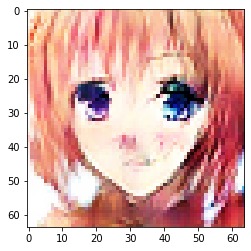

153/153 [==============================] - 22s 143ms/step - generator loss: 7959.9453 - discriminator_loss: -17474.1911
Epoch 88/250
153/153 [==============================] - ETA: 0s - generator loss: 8319.0587 - discriminator_loss: -17899.9077

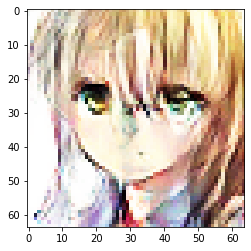

153/153 [==============================] - 22s 144ms/step - generator loss: 8360.6023 - discriminator_loss: -17911.2495
Epoch 89/250
153/153 [==============================] - ETA: 0s - generator loss: 8242.6038 - discriminator_loss: -18037.1721

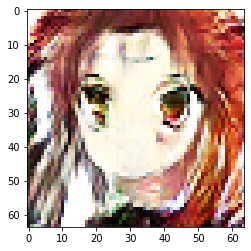

153/153 [==============================] - 23s 145ms/step - generator loss: 8201.9830 - discriminator_loss: -18038.6602
Epoch 90/250
153/153 [==============================] - ETA: 0s - generator loss: 8583.8740 - discriminator_loss: -18490.2106

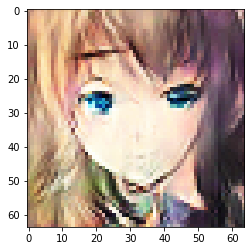

153/153 [==============================] - 23s 147ms/step - generator loss: 8622.6389 - discriminator_loss: -18503.0147
Epoch 91/250
153/153 [==============================] - ETA: 0s - generator loss: 8615.8123 - discriminator_loss: -18697.8968

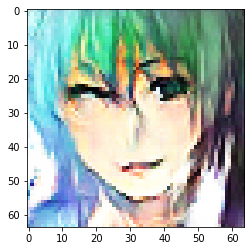

153/153 [==============================] - 22s 144ms/step - generator loss: 8555.1337 - discriminator_loss: -18680.5762
Epoch 92/250
153/153 [==============================] - ETA: 0s - generator loss: 8873.3203 - discriminator_loss: -19177.5812

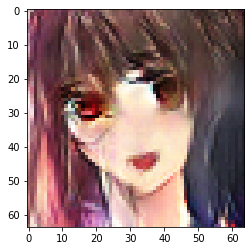

153/153 [==============================] - 23s 145ms/step - generator loss: 8911.8816 - discriminator_loss: -19174.4338
Epoch 93/250
153/153 [==============================] - ETA: 0s - generator loss: 8888.6511 - discriminator_loss: -19359.7807

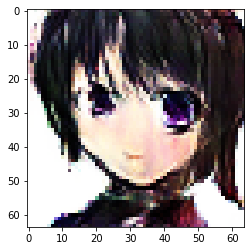

153/153 [==============================] - 23s 145ms/step - generator loss: 8843.8320 - discriminator_loss: -19357.5378
Epoch 94/250
153/153 [==============================] - ETA: 0s - generator loss: 9126.8938 - discriminator_loss: -19706.1832

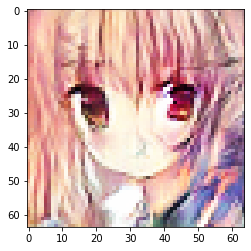

153/153 [==============================] - 22s 144ms/step - generator loss: 9166.3617 - discriminator_loss: -19713.1570
Epoch 95/250
153/153 [==============================] - ETA: 0s - generator loss: 9123.9925 - discriminator_loss: -19926.9683

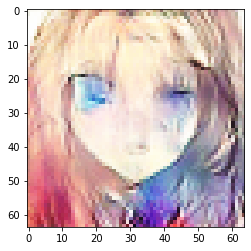

153/153 [==============================] - 23s 145ms/step - generator loss: 9096.0726 - discriminator_loss: -19935.2778
Epoch 96/250
153/153 [==============================] - ETA: 0s - generator loss: 9395.7051 - discriminator_loss: -20300.7590

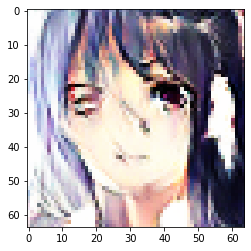

153/153 [==============================] - 23s 146ms/step - generator loss: 9445.2837 - discriminator_loss: -20299.8474
Epoch 97/250
153/153 [==============================] - ETA: 0s - generator loss: 9422.0292 - discriminator_loss: -20549.8015

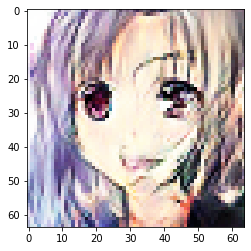

153/153 [==============================] - 23s 145ms/step - generator loss: 9387.5162 - discriminator_loss: -20562.1225
Epoch 98/250
153/153 [==============================] - ETA: 0s - generator loss: 9580.0736 - discriminator_loss: -20891.7210

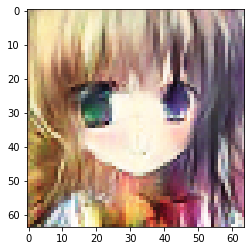

153/153 [==============================] - 23s 145ms/step - generator loss: 9633.8090 - discriminator_loss: -20880.5405
Epoch 99/250
153/153 [==============================] - ETA: 0s - generator loss: 9759.6934 - discriminator_loss: -21292.8787

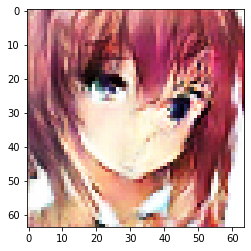

153/153 [==============================] - 23s 146ms/step - generator loss: 9709.6832 - discriminator_loss: -21287.8427
Epoch 100/250
153/153 [==============================] - ETA: 0s - generator loss: 10013.0487 - discriminator_loss: -21634.8601

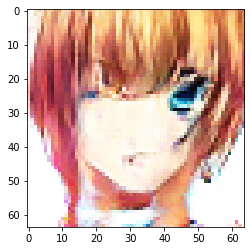

153/153 [==============================] - 23s 145ms/step - generator loss: 10067.2872 - discriminator_loss: -21632.2193
Epoch 101/250
153/153 [==============================] - ETA: 0s - generator loss: 10041.7605 - discriminator_loss: -21887.1599

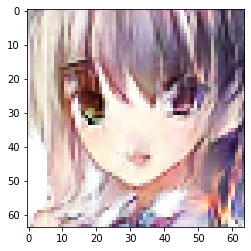

153/153 [==============================] - 23s 145ms/step - generator loss: 10007.4075 - discriminator_loss: -21904.9814
Epoch 102/250
153/153 [==============================] - ETA: 0s - generator loss: 10307.5462 - discriminator_loss: -22260.5369

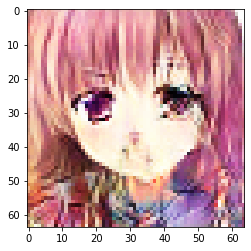

153/153 [==============================] - 23s 145ms/step - generator loss: 10355.0293 - discriminator_loss: -22273.7897
Epoch 103/250
153/153 [==============================] - ETA: 0s - generator loss: 10391.6100 - discriminator_loss: -22628.6680

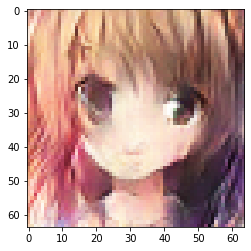

153/153 [==============================] - 23s 145ms/step - generator loss: 10339.1256 - discriminator_loss: -22622.2339
Epoch 104/250
153/153 [==============================] - ETA: 0s - generator loss: 10582.5018 - discriminator_loss: -22875.8560

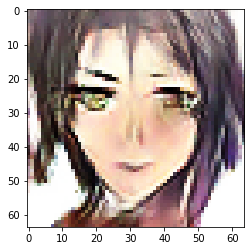

153/153 [==============================] - 23s 145ms/step - generator loss: 10637.3852 - discriminator_loss: -22888.3028
Epoch 105/250
153/153 [==============================] - ETA: 0s - generator loss: 10563.5916 - discriminator_loss: -23233.1022

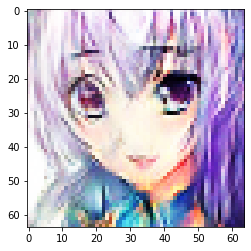

153/153 [==============================] - 23s 145ms/step - generator loss: 10502.6377 - discriminator_loss: -23222.8534
Epoch 106/250
153/153 [==============================] - ETA: 0s - generator loss: 10942.8782 - discriminator_loss: -23576.5593

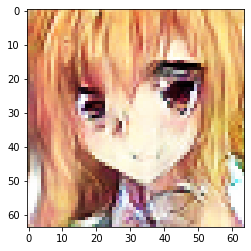

153/153 [==============================] - 23s 145ms/step - generator loss: 10988.1550 - discriminator_loss: -23570.3692
Epoch 107/250
153/153 [==============================] - ETA: 0s - generator loss: 10994.4528 - discriminator_loss: -23934.1096

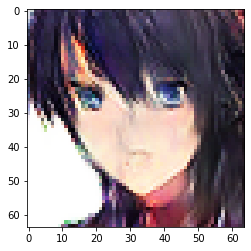

153/153 [==============================] - 23s 144ms/step - generator loss: 10941.8768 - discriminator_loss: -23936.4629
Epoch 108/250
153/153 [==============================] - ETA: 0s - generator loss: 11290.4430 - discriminator_loss: -24320.1655

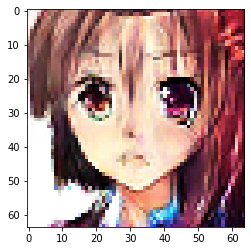

153/153 [==============================] - 23s 145ms/step - generator loss: 11349.7370 - discriminator_loss: -24322.8201
Epoch 109/250
153/153 [==============================] - ETA: 0s - generator loss: 11288.2244 - discriminator_loss: -24779.9278

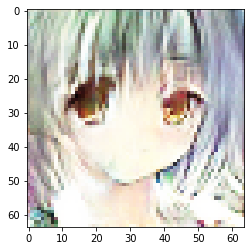

153/153 [==============================] - 23s 145ms/step - generator loss: 11234.3323 - discriminator_loss: -24784.0558
Epoch 110/250
153/153 [==============================] - ETA: 0s - generator loss: 11544.1563 - discriminator_loss: -24991.4244

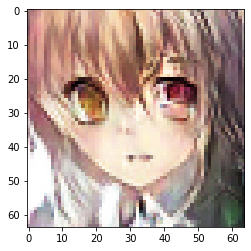

153/153 [==============================] - 23s 145ms/step - generator loss: 11590.4785 - discriminator_loss: -25020.6215
Epoch 111/250
153/153 [==============================] - ETA: 0s - generator loss: 11556.2998 - discriminator_loss: -25293.3421

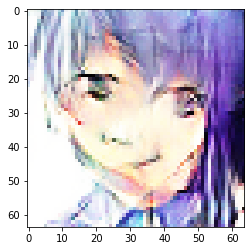

153/153 [==============================] - 23s 145ms/step - generator loss: 11482.0434 - discriminator_loss: -25283.9164
Epoch 112/250
153/153 [==============================] - ETA: 0s - generator loss: 11938.1669 - discriminator_loss: -25975.8858

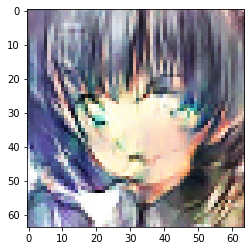

153/153 [==============================] - 23s 146ms/step - generator loss: 12001.6985 - discriminator_loss: -25962.1128
Epoch 113/250
153/153 [==============================] - ETA: 0s - generator loss: 11932.6523 - discriminator_loss: -26139.4080

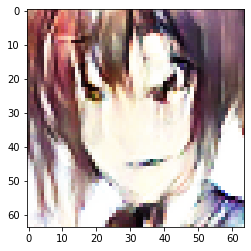

153/153 [==============================] - 22s 144ms/step - generator loss: 11879.1732 - discriminator_loss: -26149.9589
Epoch 114/250
153/153 [==============================] - ETA: 0s - generator loss: 12134.8414 - discriminator_loss: -26465.9575

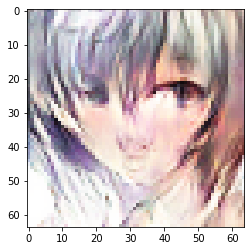

153/153 [==============================] - 23s 145ms/step - generator loss: 12197.4374 - discriminator_loss: -26476.7776
Epoch 115/250
153/153 [==============================] - ETA: 0s - generator loss: 12265.2728 - discriminator_loss: -26839.9182

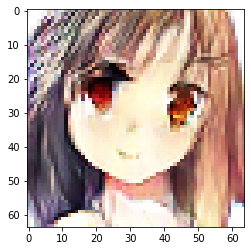

153/153 [==============================] - 23s 146ms/step - generator loss: 12235.4462 - discriminator_loss: -26863.4550
Epoch 116/250
153/153 [==============================] - ETA: 0s - generator loss: 12581.5558 - discriminator_loss: -27296.8563

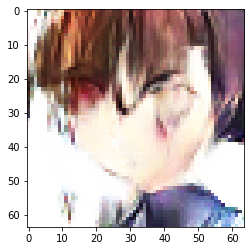

153/153 [==============================] - 23s 146ms/step - generator loss: 12640.3872 - discriminator_loss: -27287.5808
Epoch 117/250
153/153 [==============================] - ETA: 0s - generator loss: 12542.7984 - discriminator_loss: -27603.5180

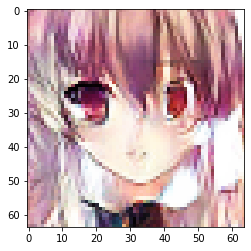

153/153 [==============================] - 23s 146ms/step - generator loss: 12523.3938 - discriminator_loss: -27634.1241
Epoch 118/250
153/153 [==============================] - ETA: 0s - generator loss: 12728.2252 - discriminator_loss: -27875.6731

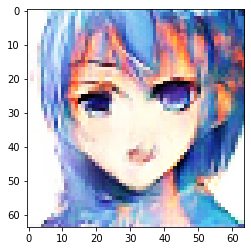

153/153 [==============================] - 23s 145ms/step - generator loss: 12785.6627 - discriminator_loss: -27884.0019
Epoch 119/250
153/153 [==============================] - ETA: 0s - generator loss: 12964.7451 - discriminator_loss: -28426.6351

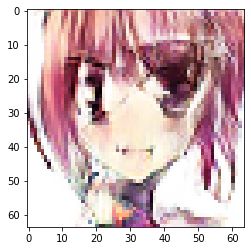

153/153 [==============================] - 23s 145ms/step - generator loss: 12934.7170 - discriminator_loss: -28444.3724
Epoch 120/250
153/153 [==============================] - ETA: 0s - generator loss: 13254.6683 - discriminator_loss: -28735.0478

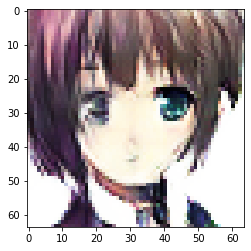

153/153 [==============================] - 23s 145ms/step - generator loss: 13320.5807 - discriminator_loss: -28735.4502
Epoch 121/250
153/153 [==============================] - ETA: 0s - generator loss: 13261.6591 - discriminator_loss: -29160.0468

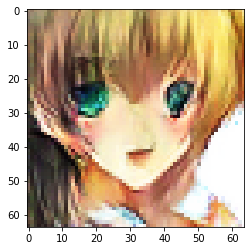

153/153 [==============================] - 23s 145ms/step - generator loss: 13190.0914 - discriminator_loss: -29156.3571
Epoch 122/250
153/153 [==============================] - ETA: 0s - generator loss: 13472.9067 - discriminator_loss: -29502.1458

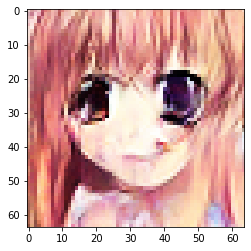

153/153 [==============================] - 23s 144ms/step - generator loss: 13544.9967 - discriminator_loss: -29497.5988
Epoch 123/250
153/153 [==============================] - ETA: 0s - generator loss: 13549.2879 - discriminator_loss: -29838.9684

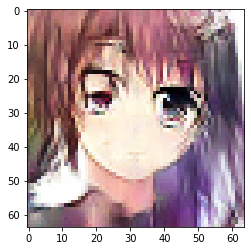

153/153 [==============================] - 23s 145ms/step - generator loss: 13484.4956 - discriminator_loss: -29834.3440
Epoch 124/250
153/153 [==============================] - ETA: 0s - generator loss: 13862.0323 - discriminator_loss: -30152.4729

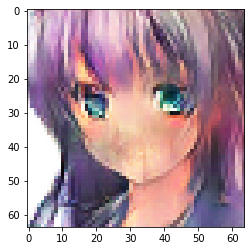

153/153 [==============================] - 22s 144ms/step - generator loss: 13924.8839 - discriminator_loss: -30165.4376
Epoch 125/250
153/153 [==============================] - ETA: 0s - generator loss: 13983.5694 - discriminator_loss: -30712.9202

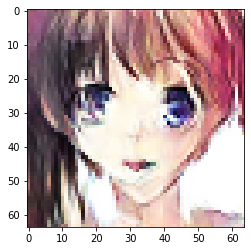

153/153 [==============================] - 23s 144ms/step - generator loss: 13925.7700 - discriminator_loss: -30729.0244
Epoch 126/250
153/153 [==============================] - ETA: 0s - generator loss: 14308.1320 - discriminator_loss: -31120.1568

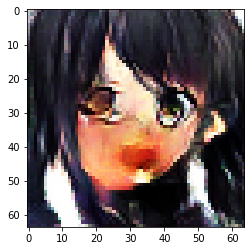

153/153 [==============================] - 23s 145ms/step - generator loss: 14377.2711 - discriminator_loss: -31133.0426
Epoch 127/250
153/153 [==============================] - ETA: 0s - generator loss: 14247.9598 - discriminator_loss: -31340.8617

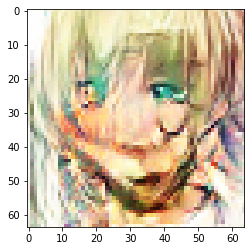

153/153 [==============================] - 23s 144ms/step - generator loss: 14149.5273 - discriminator_loss: -31315.8846
Epoch 128/250
153/153 [==============================] - ETA: 0s - generator loss: 14658.1306 - discriminator_loss: -31824.2093

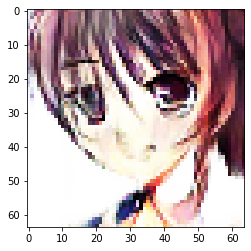

153/153 [==============================] - 23s 147ms/step - generator loss: 14737.1706 - discriminator_loss: -31837.8168
Epoch 129/250
153/153 [==============================] - ETA: 0s - generator loss: 14621.2594 - discriminator_loss: -32170.1163

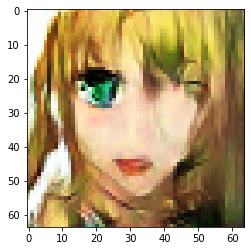

153/153 [==============================] - 22s 144ms/step - generator loss: 14558.7375 - discriminator_loss: -32172.2516
Epoch 130/250
153/153 [==============================] - ETA: 0s - generator loss: 14962.6082 - discriminator_loss: -32586.7806

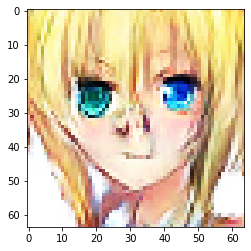

153/153 [==============================] - 23s 145ms/step - generator loss: 15049.4062 - discriminator_loss: -32556.9782
Epoch 131/250
153/153 [==============================] - ETA: 0s - generator loss: 15118.8019 - discriminator_loss: -33166.5828

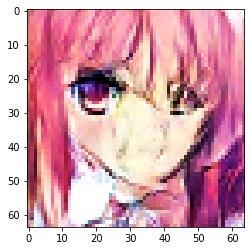

153/153 [==============================] - 23s 145ms/step - generator loss: 15076.2409 - discriminator_loss: -33189.8459
Epoch 132/250
153/153 [==============================] - ETA: 0s - generator loss: 15322.4233 - discriminator_loss: -33484.3567

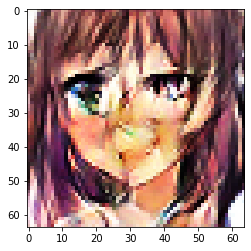

153/153 [==============================] - 23s 145ms/step - generator loss: 15390.7736 - discriminator_loss: -33490.3746
Epoch 133/250
153/153 [==============================] - ETA: 0s - generator loss: 15356.2681 - discriminator_loss: -33823.3631

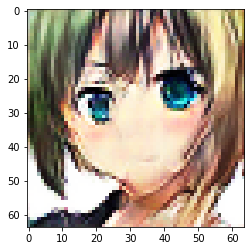

153/153 [==============================] - 23s 145ms/step - generator loss: 15284.5851 - discriminator_loss: -33810.3186
Epoch 134/250
153/153 [==============================] - ETA: 0s - generator loss: 15703.2518 - discriminator_loss: -34209.1316

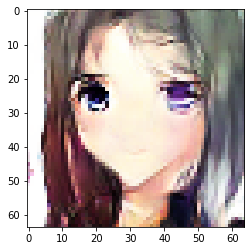

153/153 [==============================] - 23s 145ms/step - generator loss: 15759.6711 - discriminator_loss: -34202.7338
Epoch 135/250
153/153 [==============================] - ETA: 0s - generator loss: 15800.2070 - discriminator_loss: -34712.3320

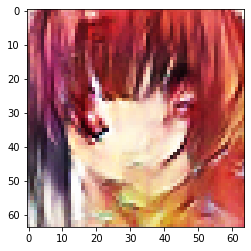

153/153 [==============================] - 23s 145ms/step - generator loss: 15737.0368 - discriminator_loss: -34726.9546
Epoch 136/250
153/153 [==============================] - ETA: 0s - generator loss: 15909.1581 - discriminator_loss: -35011.8064

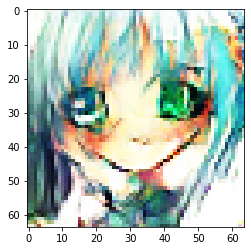

153/153 [==============================] - 22s 144ms/step - generator loss: 15986.8862 - discriminator_loss: -35019.8741
Epoch 137/250
153/153 [==============================] - ETA: 0s - generator loss: 16142.1524 - discriminator_loss: -35626.3886

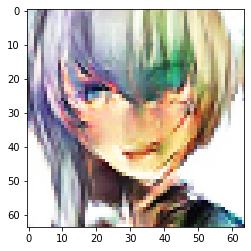

153/153 [==============================] - 22s 144ms/step - generator loss: 16045.6920 - discriminator_loss: -35599.6399
Epoch 138/250
153/153 [==============================] - ETA: 0s - generator loss: 16492.8260 - discriminator_loss: -36062.4541

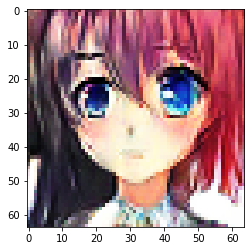

153/153 [==============================] - 23s 147ms/step - generator loss: 16574.5157 - discriminator_loss: -36053.2685
Epoch 139/250
153/153 [==============================] - ETA: 0s - generator loss: 16567.0312 - discriminator_loss: -36533.8434

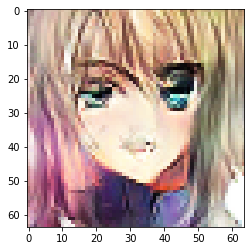

153/153 [==============================] - 23s 145ms/step - generator loss: 16472.9989 - discriminator_loss: -36526.2781
Epoch 140/250
153/153 [==============================] - ETA: 0s - generator loss: 16865.4131 - discriminator_loss: -36880.1717

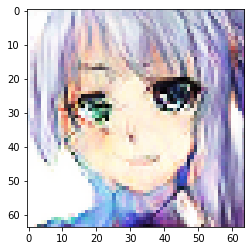

153/153 [==============================] - 23s 146ms/step - generator loss: 16950.4556 - discriminator_loss: -36883.0137
Epoch 141/250
153/153 [==============================] - ETA: 0s - generator loss: 16801.7762 - discriminator_loss: -37199.8523

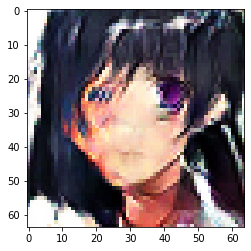

153/153 [==============================] - 23s 145ms/step - generator loss: 16717.2359 - discriminator_loss: -37208.4536
Epoch 142/250
153/153 [==============================] - ETA: 0s - generator loss: 17305.0758 - discriminator_loss: -37581.7373

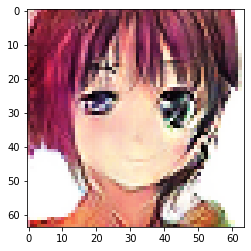

153/153 [==============================] - 23s 145ms/step - generator loss: 17397.7357 - discriminator_loss: -37575.0343
Epoch 143/250
153/153 [==============================] - ETA: 0s - generator loss: 17181.5029 - discriminator_loss: -37972.6896

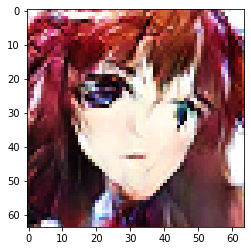

153/153 [==============================] - 22s 144ms/step - generator loss: 17100.3684 - discriminator_loss: -37992.3003
Epoch 144/250
153/153 [==============================] - ETA: 0s - generator loss: 17508.5357 - discriminator_loss: -38526.2403

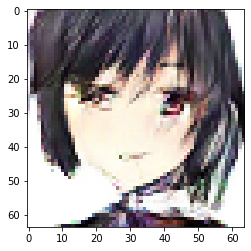

153/153 [==============================] - 23s 145ms/step - generator loss: 17602.5079 - discriminator_loss: -38541.7219
Epoch 145/250
153/153 [==============================] - ETA: 0s - generator loss: 17629.6234 - discriminator_loss: -38836.0379

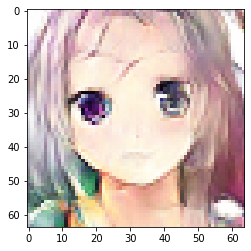

153/153 [==============================] - 23s 144ms/step - generator loss: 17564.8692 - discriminator_loss: -38857.0846
Epoch 146/250
153/153 [==============================] - ETA: 0s - generator loss: 17934.6326 - discriminator_loss: -39237.2122

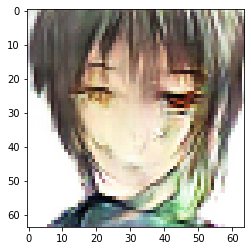

153/153 [==============================] - 23s 145ms/step - generator loss: 18026.2405 - discriminator_loss: -39218.6868
Epoch 147/250
153/153 [==============================] - ETA: 0s - generator loss: 18078.9619 - discriminator_loss: -39884.0739

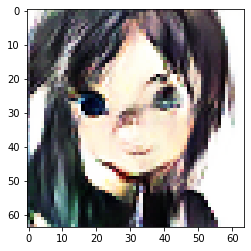

153/153 [==============================] - 23s 145ms/step - generator loss: 17939.9702 - discriminator_loss: -39847.9656
Epoch 148/250
153/153 [==============================] - ETA: 0s - generator loss: 18234.4176 - discriminator_loss: -40073.3647

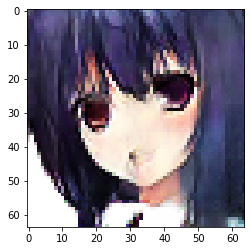

153/153 [==============================] - 23s 146ms/step - generator loss: 18338.3332 - discriminator_loss: -40072.4430
Epoch 149/250
153/153 [==============================] - ETA: 0s - generator loss: 18338.6636 - discriminator_loss: -40638.8599

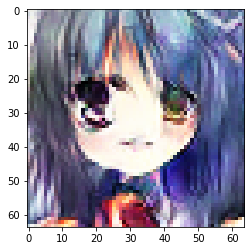

153/153 [==============================] - 23s 145ms/step - generator loss: 18254.6211 - discriminator_loss: -40650.4836
Epoch 150/250
153/153 [==============================] - ETA: 0s - generator loss: 18713.4937 - discriminator_loss: -41156.5095

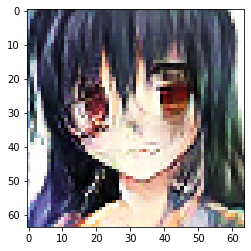

153/153 [==============================] - 23s 145ms/step - generator loss: 18809.7230 - discriminator_loss: -41181.9869
Epoch 151/250
153/153 [==============================] - ETA: 0s - generator loss: 18685.6752 - discriminator_loss: -41393.2983

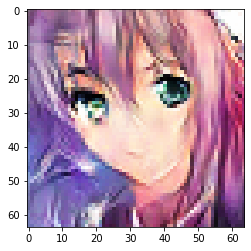

153/153 [==============================] - 23s 146ms/step - generator loss: 18606.6306 - discriminator_loss: -41399.2087
Epoch 152/250
153/153 [==============================] - ETA: 0s - generator loss: 19085.9044 - discriminator_loss: -41935.5736

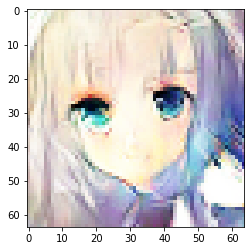

153/153 [==============================] - 23s 145ms/step - generator loss: 19191.5499 - discriminator_loss: -41949.3199
Epoch 153/250
153/153 [==============================] - ETA: 0s - generator loss: 19139.7845 - discriminator_loss: -42566.6316

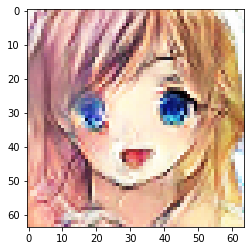

153/153 [==============================] - 23s 145ms/step - generator loss: 19070.2574 - discriminator_loss: -42582.1729
Epoch 154/250
153/153 [==============================] - ETA: 0s - generator loss: 19455.5555 - discriminator_loss: -42923.1864

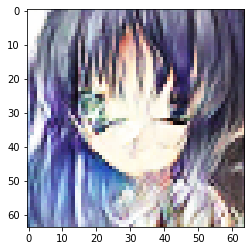

153/153 [==============================] - 23s 145ms/step - generator loss: 19554.8946 - discriminator_loss: -42957.5476
Epoch 155/250
153/153 [==============================] - ETA: 0s - generator loss: 19602.4247 - discriminator_loss: -43232.4716

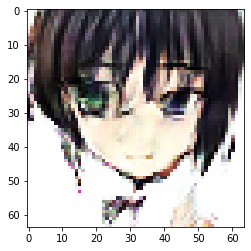

153/153 [==============================] - 23s 145ms/step - generator loss: 19559.4663 - discriminator_loss: -43280.0749
Epoch 156/250
153/153 [==============================] - ETA: 0s - generator loss: 20010.8737 - discriminator_loss: -43926.3321

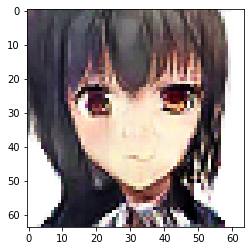

153/153 [==============================] - 23s 145ms/step - generator loss: 20119.0169 - discriminator_loss: -43874.2407
Epoch 157/250
153/153 [==============================] - ETA: 0s - generator loss: 19908.0497 - discriminator_loss: -44066.7887

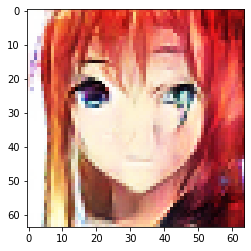

153/153 [==============================] - 23s 146ms/step - generator loss: 19810.1201 - discriminator_loss: -44065.2641
Epoch 158/250
153/153 [==============================] - ETA: 0s - generator loss: 20222.4040 - discriminator_loss: -44794.3015

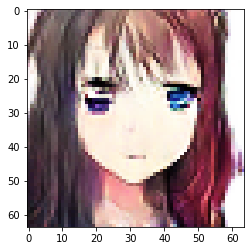

153/153 [==============================] - 23s 146ms/step - generator loss: 20337.9973 - discriminator_loss: -44813.9402
Epoch 159/250
153/153 [==============================] - ETA: 0s - generator loss: 20293.2370 - discriminator_loss: -45277.2886

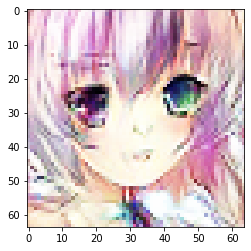

153/153 [==============================] - 23s 146ms/step - generator loss: 20185.2469 - discriminator_loss: -45280.7449
Epoch 160/250
153/153 [==============================] - ETA: 0s - generator loss: 20716.1832 - discriminator_loss: -45604.4010

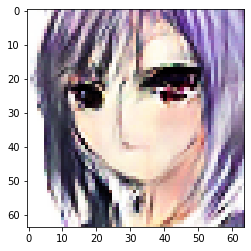

153/153 [==============================] - 23s 146ms/step - generator loss: 20832.1255 - discriminator_loss: -45572.9992
Epoch 161/250
153/153 [==============================] - ETA: 0s - generator loss: 20821.1636 - discriminator_loss: -45930.3249

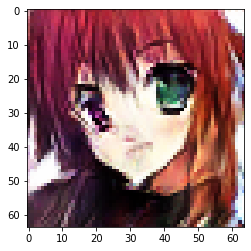

153/153 [==============================] - 22s 144ms/step - generator loss: 20677.6872 - discriminator_loss: -45889.1347
Epoch 162/250
153/153 [==============================] - ETA: 0s - generator loss: 21191.3371 - discriminator_loss: -46452.1767

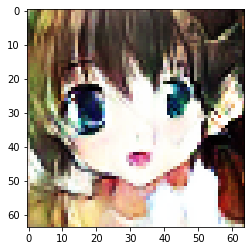

153/153 [==============================] - 23s 145ms/step - generator loss: 21298.0869 - discriminator_loss: -46457.0939
Epoch 163/250
153/153 [==============================] - ETA: 0s - generator loss: 21144.5669 - discriminator_loss: -46983.1044

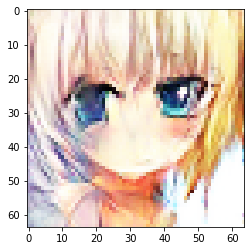

153/153 [==============================] - 23s 144ms/step - generator loss: 21057.6988 - discriminator_loss: -46993.2106
Epoch 164/250
153/153 [==============================] - ETA: 0s - generator loss: 21566.9707 - discriminator_loss: -47460.6686

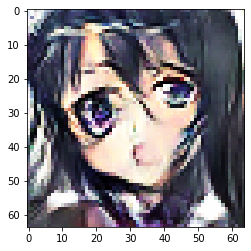

153/153 [==============================] - 22s 144ms/step - generator loss: 21687.2339 - discriminator_loss: -47506.5812
Epoch 165/250
153/153 [==============================] - ETA: 0s - generator loss: 21601.2473 - discriminator_loss: -47965.3588

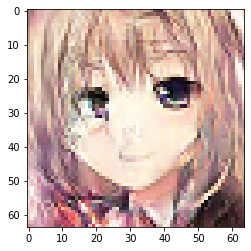

153/153 [==============================] - 23s 144ms/step - generator loss: 21507.9232 - discriminator_loss: -47966.3464
Epoch 166/250
153/153 [==============================] - ETA: 0s - generator loss: 22225.8835 - discriminator_loss: -48417.9796

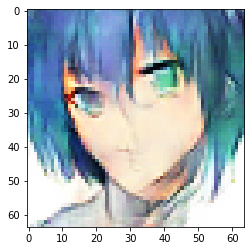

153/153 [==============================] - 23s 144ms/step - generator loss: 22339.0037 - discriminator_loss: -48414.6089
Epoch 167/250
153/153 [==============================] - ETA: 0s - generator loss: 21985.0016 - discriminator_loss: -48803.0833

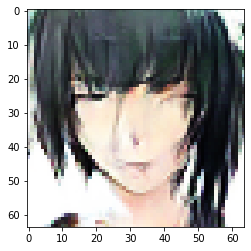

153/153 [==============================] - 23s 145ms/step - generator loss: 21901.3728 - discriminator_loss: -48812.0062
Epoch 168/250
153/153 [==============================] - ETA: 0s - generator loss: 22543.6883 - discriminator_loss: -49463.4373

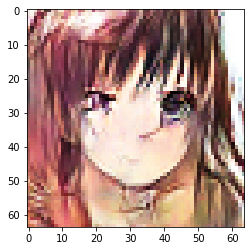

153/153 [==============================] - 22s 144ms/step - generator loss: 22665.1987 - discriminator_loss: -49488.5050
Epoch 169/250
153/153 [==============================] - ETA: 0s - generator loss: 22631.3707 - discriminator_loss: -50057.1310

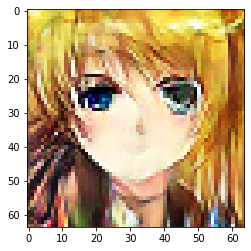

153/153 [==============================] - 23s 144ms/step - generator loss: 22550.5555 - discriminator_loss: -50093.1030
Epoch 170/250
153/153 [==============================] - ETA: 0s - generator loss: 22895.8661 - discriminator_loss: -50262.8121

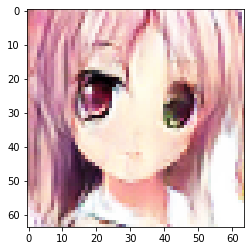

153/153 [==============================] - 23s 144ms/step - generator loss: 23013.2507 - discriminator_loss: -50337.5050
Epoch 171/250
153/153 [==============================] - ETA: 0s - generator loss: 22789.0805 - discriminator_loss: -50834.5408

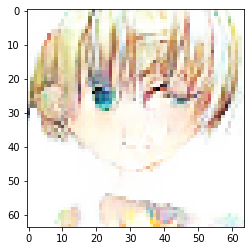

153/153 [==============================] - 23s 145ms/step - generator loss: 22668.6279 - discriminator_loss: -50846.7007
Epoch 172/250
153/153 [==============================] - ETA: 0s - generator loss: 23571.7105 - discriminator_loss: -51528.6717

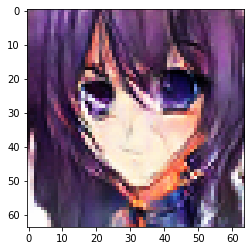

153/153 [==============================] - 23s 146ms/step - generator loss: 23683.9990 - discriminator_loss: -51553.0570
Epoch 173/250
153/153 [==============================] - ETA: 0s - generator loss: 23327.8749 - discriminator_loss: -51777.9787

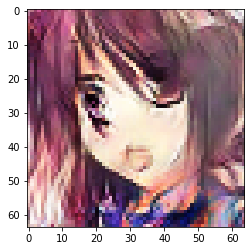

153/153 [==============================] - 23s 145ms/step - generator loss: 23198.2600 - discriminator_loss: -51762.2398
Epoch 174/250
153/153 [==============================] - ETA: 0s - generator loss: 23842.5129 - discriminator_loss: -52461.2674

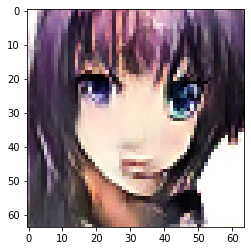

153/153 [==============================] - 23s 144ms/step - generator loss: 23980.5320 - discriminator_loss: -52407.9579
Epoch 175/250
153/153 [==============================] - ETA: 0s - generator loss: 23740.0840 - discriminator_loss: -52706.8277

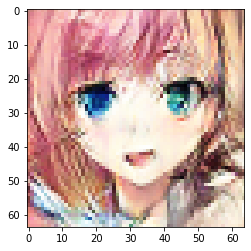

153/153 [==============================] - 23s 145ms/step - generator loss: 23644.5174 - discriminator_loss: -52738.5155
Epoch 176/250
153/153 [==============================] - ETA: 0s - generator loss: 24130.8246 - discriminator_loss: -53428.2910

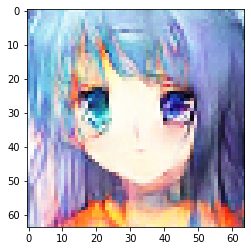

153/153 [==============================] - 23s 146ms/step - generator loss: 24228.0289 - discriminator_loss: -53433.3376
Epoch 177/250
153/153 [==============================] - ETA: 0s - generator loss: 24200.3231 - discriminator_loss: -53800.9927

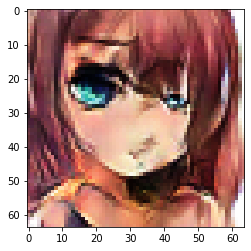

153/153 [==============================] - 23s 146ms/step - generator loss: 24080.4838 - discriminator_loss: -53807.7918
Epoch 178/250
153/153 [==============================] - ETA: 0s - generator loss: 24945.2541 - discriminator_loss: -54523.4377

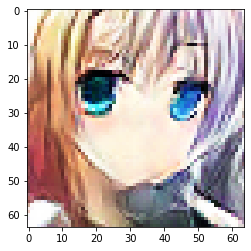

153/153 [==============================] - 23s 145ms/step - generator loss: 25090.2512 - discriminator_loss: -54511.3928
Epoch 179/250
153/153 [==============================] - ETA: 0s - generator loss: 24931.8306 - discriminator_loss: -55048.7644

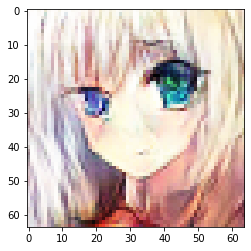

153/153 [==============================] - 23s 145ms/step - generator loss: 24880.3876 - discriminator_loss: -55078.1030
Epoch 180/250
153/153 [==============================] - ETA: 0s - generator loss: 24921.0961 - discriminator_loss: -55387.9263

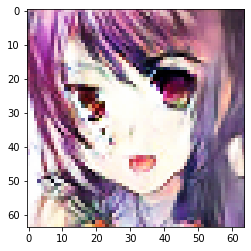

153/153 [==============================] - 23s 145ms/step - generator loss: 25071.3954 - discriminator_loss: -55381.8428
Epoch 181/250
153/153 [==============================] - ETA: 0s - generator loss: 25225.0104 - discriminator_loss: -55890.4831

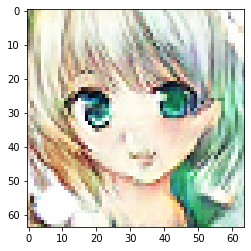

153/153 [==============================] - 23s 146ms/step - generator loss: 25077.3007 - discriminator_loss: -55863.2416
Epoch 182/250
153/153 [==============================] - ETA: 0s - generator loss: 25829.0967 - discriminator_loss: -56700.0313

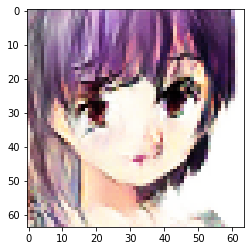

153/153 [==============================] - 23s 146ms/step - generator loss: 25956.8959 - discriminator_loss: -56732.8984
Epoch 183/250
153/153 [==============================] - ETA: 0s - generator loss: 25729.5173 - discriminator_loss: -57107.4883

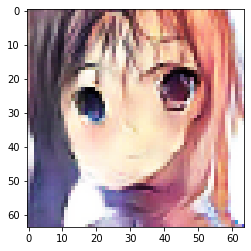

153/153 [==============================] - 23s 144ms/step - generator loss: 25594.2488 - discriminator_loss: -57110.0546
Epoch 184/250
153/153 [==============================] - ETA: 0s - generator loss: 26118.8573 - discriminator_loss: -57685.4821

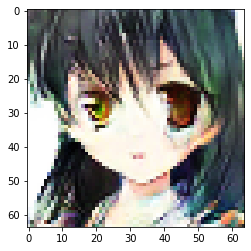

153/153 [==============================] - 23s 145ms/step - generator loss: 26260.1916 - discriminator_loss: -57679.7668
Epoch 185/250
153/153 [==============================] - ETA: 0s - generator loss: 26095.9816 - discriminator_loss: -58341.5140

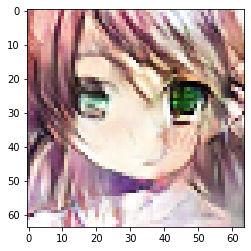

153/153 [==============================] - 23s 145ms/step - generator loss: 25958.8589 - discriminator_loss: -58341.0870
Epoch 186/250
153/153 [==============================] - ETA: 0s - generator loss: 26604.3033 - discriminator_loss: -58638.9679

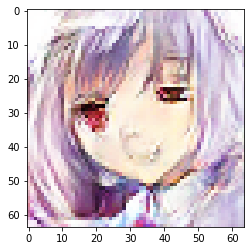

153/153 [==============================] - 23s 145ms/step - generator loss: 26733.6921 - discriminator_loss: -58665.9895
Epoch 187/250
153/153 [==============================] - ETA: 0s - generator loss: 26619.9418 - discriminator_loss: -59403.4442

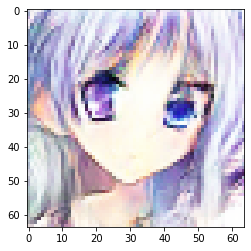

153/153 [==============================] - 22s 144ms/step - generator loss: 26523.7829 - discriminator_loss: -59449.9623
Epoch 188/250
153/153 [==============================] - ETA: 0s - generator loss: 27086.1329 - discriminator_loss: -59984.9238

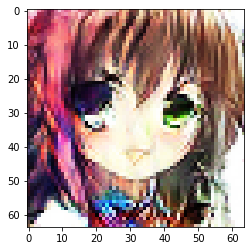

153/153 [==============================] - 22s 144ms/step - generator loss: 27221.0831 - discriminator_loss: -59965.5169
Epoch 189/250
153/153 [==============================] - ETA: 0s - generator loss: 27253.2815 - discriminator_loss: -60552.6397

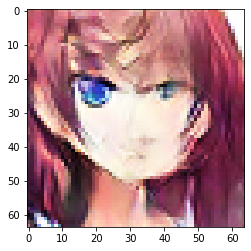

153/153 [==============================] - 23s 145ms/step - generator loss: 27150.4012 - discriminator_loss: -60549.7759
Epoch 190/250
153/153 [==============================] - ETA: 0s - generator loss: 27835.4477 - discriminator_loss: -60946.0428

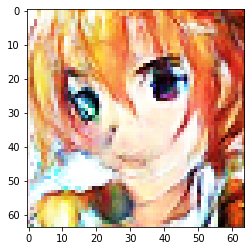

153/153 [==============================] - 22s 144ms/step - generator loss: 27988.2213 - discriminator_loss: -60926.1614
Epoch 191/250
153/153 [==============================] - ETA: 0s - generator loss: 27689.0828 - discriminator_loss: -61726.0710

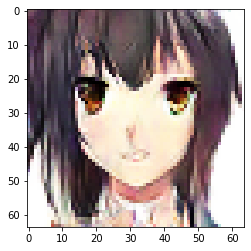

153/153 [==============================] - 23s 144ms/step - generator loss: 27514.9484 - discriminator_loss: -61706.9220
Epoch 192/250
153/153 [==============================] - ETA: 0s - generator loss: 28069.5973 - discriminator_loss: -61920.2299

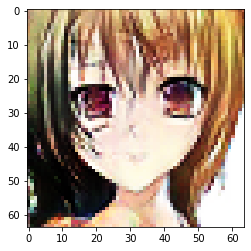

153/153 [==============================] - 22s 144ms/step - generator loss: 28223.7278 - discriminator_loss: -61933.0862
Epoch 193/250
153/153 [==============================] - ETA: 0s - generator loss: 28263.2898 - discriminator_loss: -62783.7253

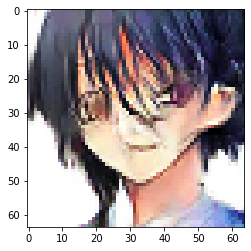

153/153 [==============================] - 23s 145ms/step - generator loss: 28125.0541 - discriminator_loss: -62806.0178
Epoch 194/250
153/153 [==============================] - ETA: 0s - generator loss: 28564.8353 - discriminator_loss: -63024.3040

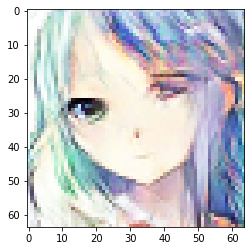

153/153 [==============================] - 23s 146ms/step - generator loss: 28715.9838 - discriminator_loss: -63030.2975
Epoch 195/250
153/153 [==============================] - ETA: 0s - generator loss: 28553.3750 - discriminator_loss: -63549.0914

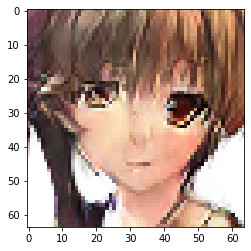

153/153 [==============================] - 23s 146ms/step - generator loss: 28399.3273 - discriminator_loss: -63555.1304
Epoch 196/250
153/153 [==============================] - ETA: 0s - generator loss: 29021.6708 - discriminator_loss: -64283.6246

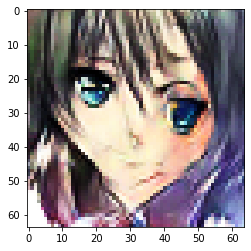

153/153 [==============================] - 23s 146ms/step - generator loss: 29175.6330 - discriminator_loss: -64273.2941
Epoch 197/250
153/153 [==============================] - ETA: 0s - generator loss: 29026.7626 - discriminator_loss: -64887.5866

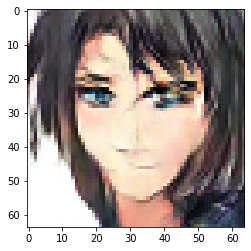

153/153 [==============================] - 23s 146ms/step - generator loss: 28841.1111 - discriminator_loss: -64878.1292
Epoch 198/250
153/153 [==============================] - ETA: 0s - generator loss: 29387.6835 - discriminator_loss: -65452.0123

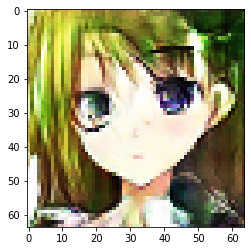

153/153 [==============================] - 23s 146ms/step - generator loss: 29520.5441 - discriminator_loss: -65454.6703
Epoch 199/250
153/153 [==============================] - ETA: 0s - generator loss: 29757.7078 - discriminator_loss: -66131.8753

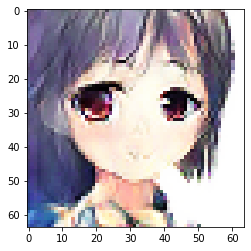

153/153 [==============================] - 23s 146ms/step - generator loss: 29612.8476 - discriminator_loss: -66130.4227
Epoch 200/250
153/153 [==============================] - ETA: 0s - generator loss: 30014.2399 - discriminator_loss: -66472.4508

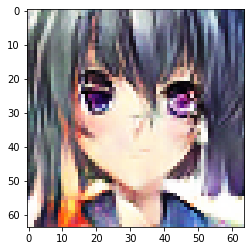

153/153 [==============================] - 23s 147ms/step - generator loss: 30164.8828 - discriminator_loss: -66523.3888
Epoch 201/250
153/153 [==============================] - ETA: 0s - generator loss: 29991.3300 - discriminator_loss: -67251.9626

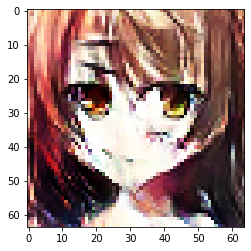

153/153 [==============================] - 23s 146ms/step - generator loss: 29890.6718 - discriminator_loss: -67290.7650
Epoch 202/250
153/153 [==============================] - ETA: 0s - generator loss: 30685.9813 - discriminator_loss: -67848.8332

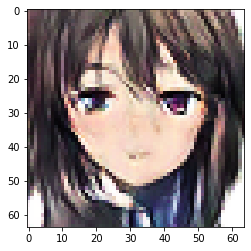

153/153 [==============================] - 23s 145ms/step - generator loss: 30838.4643 - discriminator_loss: -67803.9055
Epoch 203/250
153/153 [==============================] - ETA: 0s - generator loss: 30470.1739 - discriminator_loss: -68365.5203

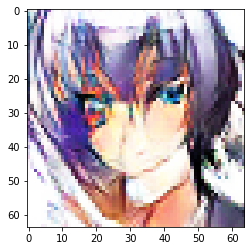

153/153 [==============================] - 23s 145ms/step - generator loss: 30232.9024 - discriminator_loss: -68287.1502
Epoch 204/250
153/153 [==============================] - ETA: 0s - generator loss: 31141.5831 - discriminator_loss: -68627.5126

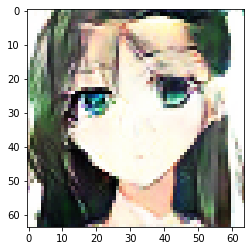

153/153 [==============================] - 23s 146ms/step - generator loss: 31295.5649 - discriminator_loss: -68649.0110
Epoch 205/250
153/153 [==============================] - ETA: 0s - generator loss: 31237.0110 - discriminator_loss: -69871.5425

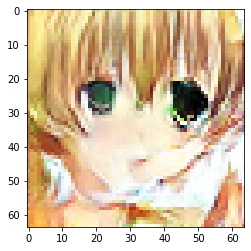

153/153 [==============================] - 23s 146ms/step - generator loss: 31099.5339 - discriminator_loss: -69917.3985
Epoch 206/250
153/153 [==============================] - ETA: 0s - generator loss: 31605.6731 - discriminator_loss: -70117.8532

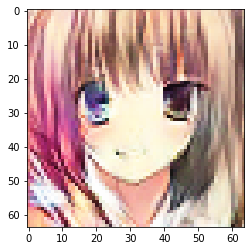

153/153 [==============================] - 23s 145ms/step - generator loss: 31753.6142 - discriminator_loss: -70179.1431
Epoch 207/250
153/153 [==============================] - ETA: 0s - generator loss: 31755.3860 - discriminator_loss: -70690.9106

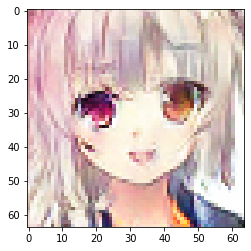

153/153 [==============================] - 23s 146ms/step - generator loss: 31704.9321 - discriminator_loss: -70771.2835
Epoch 208/250
153/153 [==============================] - ETA: 0s - generator loss: 31976.9604 - discriminator_loss: -71035.8536

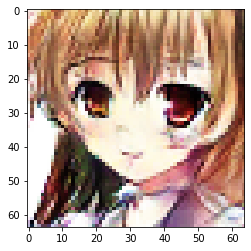

153/153 [==============================] - 23s 145ms/step - generator loss: 32132.4758 - discriminator_loss: -71035.2698
Epoch 209/250
153/153 [==============================] - ETA: 0s - generator loss: 32140.5078 - discriminator_loss: -72056.8562

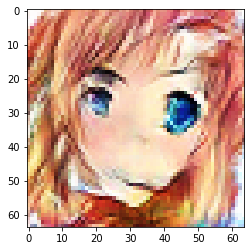

153/153 [==============================] - 23s 145ms/step - generator loss: 31951.0234 - discriminator_loss: -72026.8662
Epoch 210/250
153/153 [==============================] - ETA: 0s - generator loss: 32652.1013 - discriminator_loss: -72396.3577

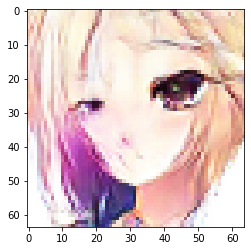

153/153 [==============================] - 23s 145ms/step - generator loss: 32789.3784 - discriminator_loss: -72425.3279
Epoch 211/250
153/153 [==============================] - ETA: 0s - generator loss: 32373.8004 - discriminator_loss: -73066.8512

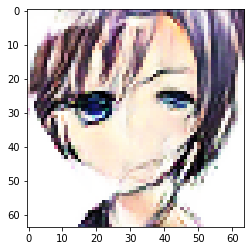

153/153 [==============================] - 23s 144ms/step - generator loss: 32259.5111 - discriminator_loss: -73108.8595
Epoch 212/250
153/153 [==============================] - ETA: 0s - generator loss: 33382.9521 - discriminator_loss: -73642.5299

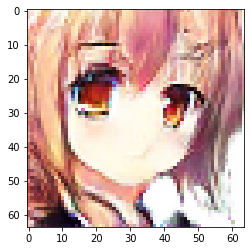

153/153 [==============================] - 23s 145ms/step - generator loss: 33570.9506 - discriminator_loss: -73639.3380
Epoch 213/250
153/153 [==============================] - ETA: 0s - generator loss: 33300.5759 - discriminator_loss: -74445.7145

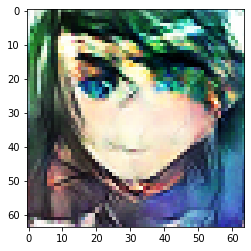

153/153 [==============================] - 22s 143ms/step - generator loss: 33180.8145 - discriminator_loss: -74482.2250
Epoch 214/250
153/153 [==============================] - ETA: 0s - generator loss: 33376.8288 - discriminator_loss: -74774.7528

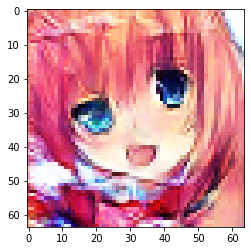

153/153 [==============================] - 23s 145ms/step - generator loss: 33561.4242 - discriminator_loss: -74792.4978
Epoch 215/250
153/153 [==============================] - ETA: 0s - generator loss: 34103.5654 - discriminator_loss: -75753.9353

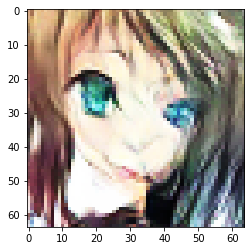

153/153 [==============================] - 23s 146ms/step - generator loss: 33947.0781 - discriminator_loss: -75759.7482
Epoch 216/250
153/153 [==============================] - ETA: 0s - generator loss: 34483.3322 - discriminator_loss: -76357.7428

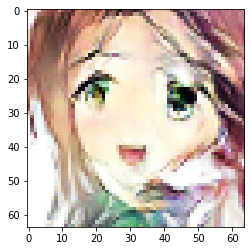

153/153 [==============================] - 22s 144ms/step - generator loss: 34682.3249 - discriminator_loss: -76421.8962
Epoch 217/250
153/153 [==============================] - ETA: 0s - generator loss: 34350.8878 - discriminator_loss: -76855.3319

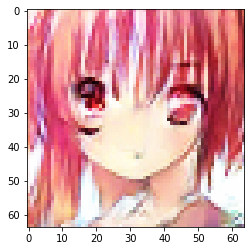

153/153 [==============================] - 23s 145ms/step - generator loss: 34199.6673 - discriminator_loss: -76872.9989
Epoch 218/250
153/153 [==============================] - ETA: 0s - generator loss: 35009.9009 - discriminator_loss: -77396.6237

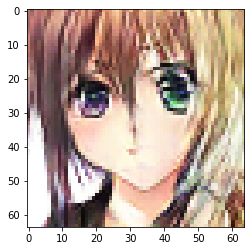

153/153 [==============================] - 23s 147ms/step - generator loss: 35169.7879 - discriminator_loss: -77349.2463
Epoch 219/250
153/153 [==============================] - ETA: 0s - generator loss: 34854.5736 - discriminator_loss: -78241.4074

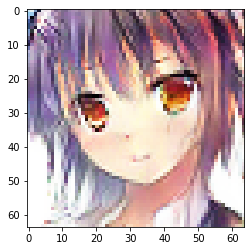

153/153 [==============================] - 23s 147ms/step - generator loss: 34681.1064 - discriminator_loss: -78206.4563
Epoch 220/250
153/153 [==============================] - ETA: 0s - generator loss: 35549.2472 - discriminator_loss: -78897.6450

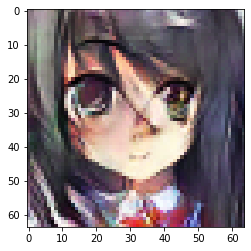

153/153 [==============================] - 23s 146ms/step - generator loss: 35716.5610 - discriminator_loss: -78977.5405
Epoch 221/250
153/153 [==============================] - ETA: 0s - generator loss: 35331.6679 - discriminator_loss: -79148.8540

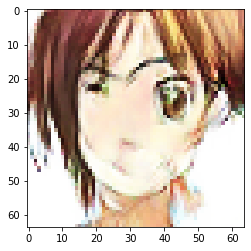

153/153 [==============================] - 23s 146ms/step - generator loss: 35198.4269 - discriminator_loss: -79198.2175
Epoch 222/250
153/153 [==============================] - ETA: 0s - generator loss: 35946.7160 - discriminator_loss: -79915.3279

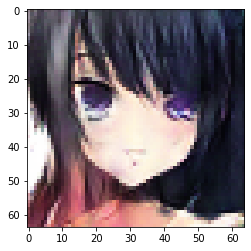

153/153 [==============================] - 23s 146ms/step - generator loss: 36143.8717 - discriminator_loss: -79943.7668
Epoch 223/250
153/153 [==============================] - ETA: 0s - generator loss: 36263.4661 - discriminator_loss: -80834.3274

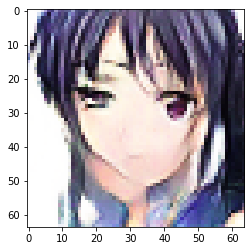

153/153 [==============================] - 23s 145ms/step - generator loss: 36141.8366 - discriminator_loss: -80895.1961
Epoch 224/250
153/153 [==============================] - ETA: 0s - generator loss: 36608.9342 - discriminator_loss: -81375.1884

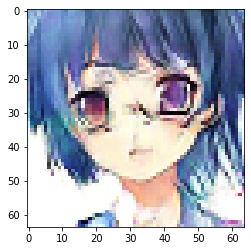

153/153 [==============================] - 23s 145ms/step - generator loss: 36782.5392 - discriminator_loss: -81370.7125
Epoch 225/250
153/153 [==============================] - ETA: 0s - generator loss: 36728.9456 - discriminator_loss: -82170.8839

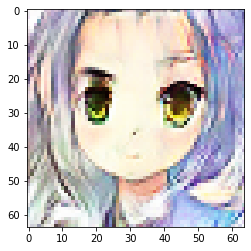

153/153 [==============================] - 23s 146ms/step - generator loss: 36578.6413 - discriminator_loss: -82189.1758
Epoch 226/250
153/153 [==============================] - ETA: 0s - generator loss: 37339.1410 - discriminator_loss: -82847.3850

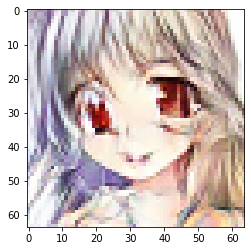

153/153 [==============================] - 23s 146ms/step - generator loss: 37525.4113 - discriminator_loss: -82859.7575
Epoch 227/250
153/153 [==============================] - ETA: 0s - generator loss: 36994.7428 - discriminator_loss: -82910.3282

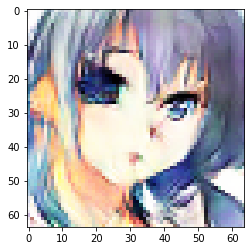

153/153 [==============================] - 23s 146ms/step - generator loss: 36881.9870 - discriminator_loss: -82977.6229
Epoch 228/250
153/153 [==============================] - ETA: 0s - generator loss: 37623.1358 - discriminator_loss: -83529.6653

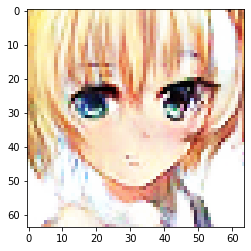

153/153 [==============================] - 23s 146ms/step - generator loss: 37835.8138 - discriminator_loss: -83530.2184
Epoch 229/250
153/153 [==============================] - ETA: 0s - generator loss: 38159.5613 - discriminator_loss: -85193.8272

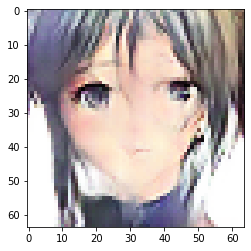

153/153 [==============================] - 23s 146ms/step - generator loss: 37953.6924 - discriminator_loss: -85161.2168
Epoch 230/250
153/153 [==============================] - ETA: 0s - generator loss: 38365.0597 - discriminator_loss: -85245.8618

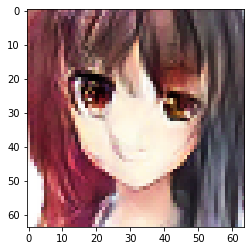

153/153 [==============================] - 23s 145ms/step - generator loss: 38566.2782 - discriminator_loss: -85270.4871
Epoch 231/250
153/153 [==============================] - ETA: 0s - generator loss: 38730.8929 - discriminator_loss: -85993.8154

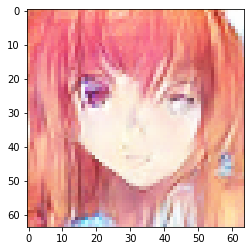

153/153 [==============================] - 23s 145ms/step - generator loss: 38593.7037 - discriminator_loss: -86041.8177
Epoch 232/250
153/153 [==============================] - ETA: 0s - generator loss: 39269.9980 - discriminator_loss: -86539.3875

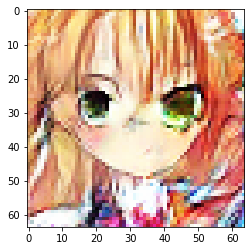

153/153 [==============================] - 22s 144ms/step - generator loss: 39386.6043 - discriminator_loss: -86578.9793
Epoch 233/250
153/153 [==============================] - ETA: 0s - generator loss: 38963.2824 - discriminator_loss: -87729.2947

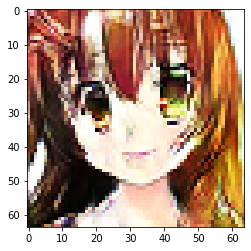

153/153 [==============================] - 23s 144ms/step - generator loss: 38833.0112 - discriminator_loss: -87799.6184
Epoch 234/250
153/153 [==============================] - ETA: 0s - generator loss: 40006.6100 - discriminator_loss: -88211.3279

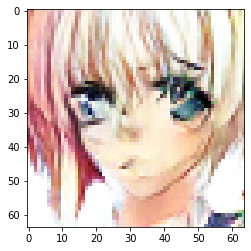

153/153 [==============================] - 23s 144ms/step - generator loss: 40219.0793 - discriminator_loss: -88260.2521
Epoch 235/250
153/153 [==============================] - ETA: 0s - generator loss: 39701.9948 - discriminator_loss: -88730.0821

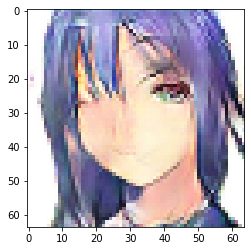

153/153 [==============================] - 23s 145ms/step - generator loss: 39557.7409 - discriminator_loss: -88770.4456
Epoch 236/250
153/153 [==============================] - ETA: 0s - generator loss: 39938.1074 - discriminator_loss: -89413.1961

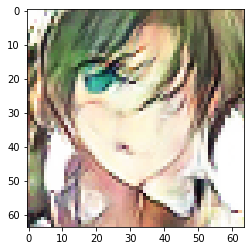

153/153 [==============================] - 22s 144ms/step - generator loss: 40107.6246 - discriminator_loss: -89450.2826
Epoch 237/250
153/153 [==============================] - ETA: 0s - generator loss: 40344.5947 - discriminator_loss: -89963.3317

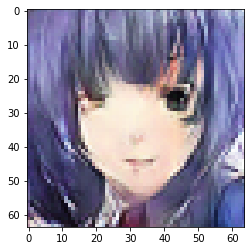

153/153 [==============================] - 23s 145ms/step - generator loss: 39985.6184 - discriminator_loss: -89815.9850
Epoch 238/250
153/153 [==============================] - ETA: 0s - generator loss: 41302.5851 - discriminator_loss: -91314.6033

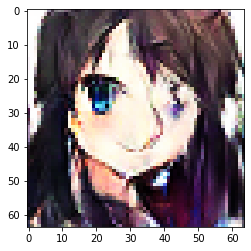

153/153 [==============================] - 23s 144ms/step - generator loss: 41497.3283 - discriminator_loss: -91257.9818
Epoch 239/250
153/153 [==============================] - ETA: 0s - generator loss: 41085.2304 - discriminator_loss: -91845.4147

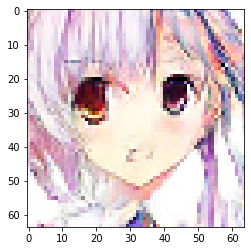

153/153 [==============================] - 23s 145ms/step - generator loss: 40892.8497 - discriminator_loss: -91886.2570
Epoch 240/250
153/153 [==============================] - ETA: 0s - generator loss: 41942.3784 - discriminator_loss: -92757.0045

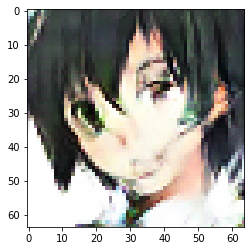

153/153 [==============================] - 22s 144ms/step - generator loss: 42105.2902 - discriminator_loss: -92793.8058
Epoch 241/250
153/153 [==============================] - ETA: 0s - generator loss: 41262.4793 - discriminator_loss: -92849.7793

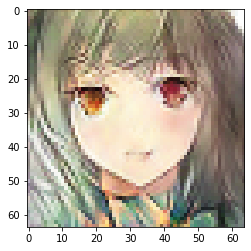

153/153 [==============================] - 23s 145ms/step - generator loss: 41062.0263 - discriminator_loss: -92850.9391
Epoch 242/250
153/153 [==============================] - ETA: 0s - generator loss: 42047.2700 - discriminator_loss: -93276.2551

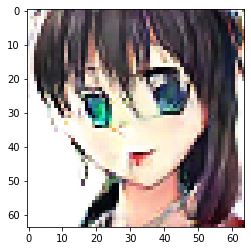

153/153 [==============================] - 23s 147ms/step - generator loss: 42275.9410 - discriminator_loss: -93243.7255
Epoch 243/250
153/153 [==============================] - ETA: 0s - generator loss: 42465.5993 - discriminator_loss: -94772.3166

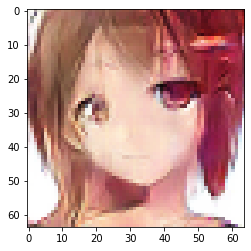

153/153 [==============================] - 23s 146ms/step - generator loss: 42263.7195 - discriminator_loss: -94786.9163
Epoch 244/250
153/153 [==============================] - ETA: 0s - generator loss: 43190.3649 - discriminator_loss: -95700.7450

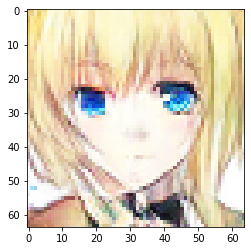

153/153 [==============================] - 23s 146ms/step - generator loss: 43433.6262 - discriminator_loss: -95681.8981
Epoch 245/250
153/153 [==============================] - ETA: 0s - generator loss: 42929.7990 - discriminator_loss: -96117.4506

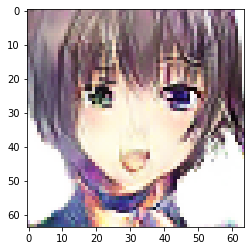

153/153 [==============================] - 23s 146ms/step - generator loss: 42766.5506 - discriminator_loss: -96159.9617
Epoch 246/250
153/153 [==============================] - ETA: 0s - generator loss: 43225.6971 - discriminator_loss: -96243.8285

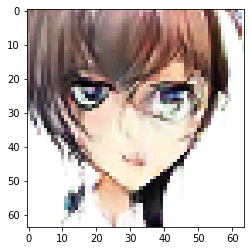

153/153 [==============================] - 23s 146ms/step - generator loss: 43422.2309 - discriminator_loss: -96237.1784
Epoch 247/250
153/153 [==============================] - ETA: 0s - generator loss: 43342.8363 - discriminator_loss: -97338.3412

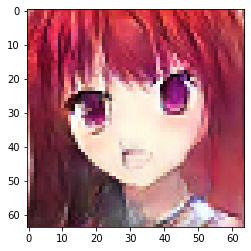

153/153 [==============================] - 23s 146ms/step - generator loss: 43057.6435 - discriminator_loss: -97262.1531
Epoch 248/250
153/153 [==============================] - ETA: 0s - generator loss: 44593.3042 - discriminator_loss: -98145.7931

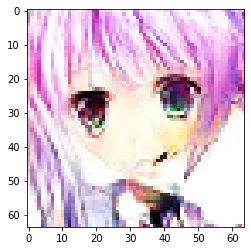

153/153 [==============================] - 23s 146ms/step - generator loss: 44823.7760 - discriminator_loss: -98207.9045
Epoch 249/250
153/153 [==============================] - ETA: 0s - generator loss: 44260.6087 - discriminator_loss: -99012.3211

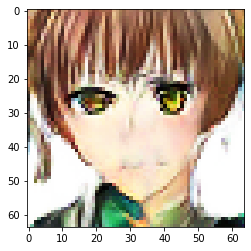

153/153 [==============================] - 23s 145ms/step - generator loss: 44036.5323 - discriminator_loss: -98989.3748
Epoch 250/250
153/153 [==============================] - ETA: 0s - generator loss: 44649.3503 - discriminator_loss: -99627.2737

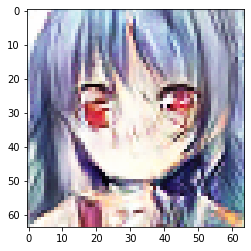

153/153 [==============================] - 23s 145ms/step - generator loss: 44902.7206 - discriminator_loss: -99600.3178


In [ ]:
with tf.device('GPU'):
  history = dcgan.fit(train_ds,epochs=250,batch_size=batch_size,callbacks=[CustomCallback()])

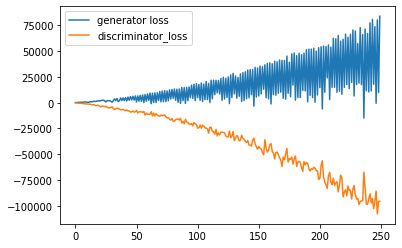

In [ ]:
plt.plot(pd.DataFrame(dcgan.history.history))
plt.legend(pd.DataFrame(dcgan.history.history))

<h1>Testing</h1>

In [ ]:
def generate_faces():
    """Generates random Anime faces"""
    
    # generate 64 images by giving 64 inputs
    noise = tf.random.normal([64,seed_size])
    generated_images = dcgan.generator(noise)

    fig = plt.figure(figsize=(12,12))
    for i in range(generated_images.shape[0]):
        plt.subplot(8,8,i+1)
        # Convert to range [0,1] for plt.imshow()
        plt.imshow((generated_images[i,:,:,:]*0.5+0.5))
        plt.axis("off")
    plt.show()

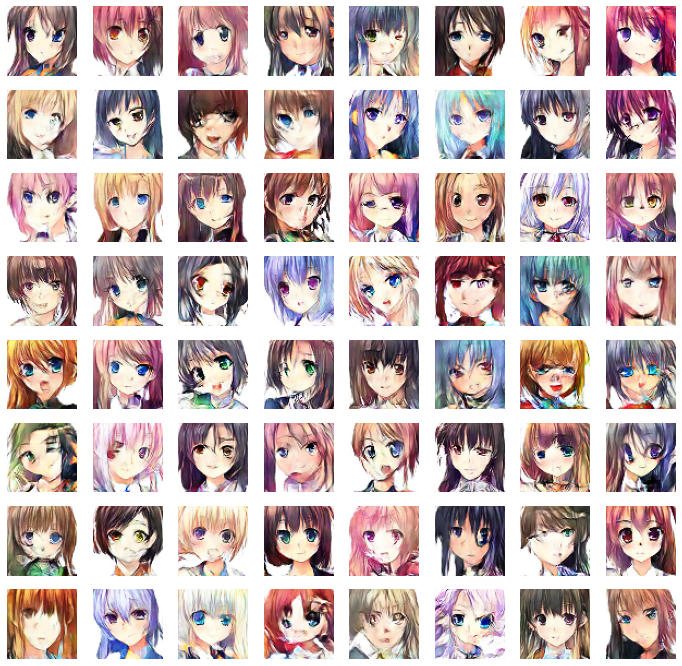

In [ ]:
generate_faces()